In [70]:
# Standard libraries
import os
import calendar
import random
import math
import logging
import scipy
import pdb
import copy

import seaborn         as sns
import pandas          as pd
import numpy           as np
import datetime        as dt
import statsmodels.api as sm

from pandas     import datetime
from matplotlib import pyplot as plt
# Linear Regression
from sklearn.linear_model import LinearRegression
# GPR imports
from sklearn.gaussian_process  import GaussianProcessRegressor
from sklearn.gaussian_process  import kernels
# Preprocessing imports
from sklearn                   import preprocessing
from sklearn.preprocessing     import LabelEncoder
from sklearn.preprocessing     import MinMaxScaler
from sklearn.preprocessing     import StandardScaler
from sklearn.model_selection   import train_test_split
# SVR import
from sklearn                   import svm
# Automated feature selection imports
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_regression
# Regression metrics
from sklearn.metrics           import mean_squared_error
from sklearn.metrics           import r2_score
from sklearn.metrics           import mean_absolute_error

# XGBoost libraries
import xgboost
from   xgboost.sklearn         import XGBRegressor
# Pytorch imports
import  torch
from    torch                  import nn
from    torch                  import optim
from    torch.nn               import functional as F
from    torch.utils.data       import TensorDataset, DataLoader
from    torch                  import optim
from    torch.optim            import lr_scheduler
from    torch.autograd         import Variable 

# Autoregression plots
from statsmodels.graphics.tsaplots      import plot_acf, plot_pacf
# Misc imports
from __future__  import division, print_function, absolute_import
from collections import OrderedDict
from copy import deepcopy

plt.rcParams["figure.figsize"] = (45,20)
%matplotlib inline

C:\Users\denis\AppData\Local\Temp/ipykernel_7332/2380885693.py:17: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas     import datetime


In [51]:
def mda(actual: np.ndarray, predicted: np.ndarray):
    "Mean Directional Accuracy"
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])))

In [847]:
# find households that share same consumption patterns
# read info households
path = os.getcwd()+"/data/informations_households.csv"
hh_info = pd.read_csv(path)


max_num = 100
block_nums = [85, 86,87] # comfortable, L

####
tot_num=0
path = os.getcwd()+"/data/hc_0.csv"
data = pd.read_csv(path)
ids = weather_energy_info.LCLid.unique()
tot_num = tot_num+len(ids)
tot_num = min(tot_num, max_num)


path = os.getcwd()+"/data/hc_0.csv"
data = pd.read_csv(path)
ids = data.LCLid.unique()

means_all=[]
hh_ids = []
for id in ids:
    # get df
    #print(data[data.LCLid == id])
    df_1p = weather_energy_info[weather_energy_info.LCLid == id]#get_data_of_a_person(block_num, id,crop_years=False)
#     if len(df_1p.date)<365*48:
#         print(str(id) + ' has less than 1 year of data')
#         continue
    means = df_1p.groupby('time', as_index=False)['energy'].mean()
    means = np.array(means.energy.values, dtype=float)
#     if len(means) != 48:
#         print('?')
#         continue
    if means.any():
        means_all.append(means)
    hh_ids.append(id)
    if len(hh_ids)==tot_num:
        break
tot_num = len(means_all)
    
# SELECT   
sel_num = 30
sel_num = min(sel_num, tot_num)

# manipulate!
# compute mean over all
means_av = means_all[0]
for i in np.arange(1,tot_num):
    means_av = means_av + means_all[i]
    
means_av = means_av/tot_num
devs = []
for i in np.arange(tot_num):
    devs.append(((means_all[i] - means_av) ** 2).mean(axis=0))
best_sub = sorted(range(len(devs)), key = lambda sub: devs[sub])[:sel_num]

# find best set of households
best_ids = [hh_ids[i] for i in list(best_sub)]
means_filt = [list(means_all[i]) for i in list(best_sub)]
print(list(best_sub))
print('Best ids', best_ids)

[3, 9, 7, 17, 10, 18, 28, 27, 12, 14, 35, 16, 25, 30, 40, 37, 34, 38, 33, 11, 20, 13, 5, 0, 8, 41, 22, 1, 42, 24]
Best ids ['MAC001074', 'MAC003348', 'MAC003281', 'MAC003463', 'MAC003388', 'MAC003482', 'MAC003680', 'MAC003668', 'MAC003400', 'MAC003423', 'MAC003805', 'MAC003449', 'MAC003646', 'MAC003718', 'MAC003856', 'MAC003826', 'MAC003775', 'MAC003844', 'MAC003740', 'MAC003394', 'MAC003557', 'MAC003422', 'MAC003239', 'MAC000002', 'MAC003305', 'MAC003863', 'MAC003579', 'MAC000246', 'MAC003874', 'MAC003613']


# Single household

In [848]:
# loading the data
alldata = pd.read_csv("data/hc_0.csv")

df = alldata.copy()
df.reset_index(drop=True, inplace=True)
df.head()

Unnamed: 0                         tstp      LCLid energy(kWh/hh)
0           0  2012-10-12 00:30:00.0000000  MAC000002             0 
1           1  2012-10-12 01:00:00.0000000  MAC000002             0 
2           2  2012-10-12 01:30:00.0000000  MAC000002             0 
3           3  2012-10-12 02:00:00.0000000  MAC000002             0 
4           4  2012-10-12 02:30:00.0000000  MAC000002             0

In [37]:
# converting timestamps into datetime format
df['tstp'] = df['tstp'].astype('datetime64[s]')

In [38]:
# adding time features
df.loc[:,'datetime'] = pd.to_datetime(df.loc[:,'tstp'], '%Y-%m-%d %H:%M:%S')
df.loc[:,'date'] = df.loc[:,'tstp'].dt.date
df.loc[:,'month'] = df.loc[:,'datetime'].dt.month
df.loc[:,'day_of_month'] = df.loc[:,'datetime'].dt.day
df.loc[:,'time'] = df.loc[:,'datetime'].dt.time
df.loc[:,'hour'] = df.loc[:,'datetime'].dt.hour
df.loc[:,'minute'] = df.loc[:,'datetime'].dt.minute
df.loc[:,'weekday'] = df.loc[:,'datetime'].dt.weekday

In [39]:
# deleting unnecessary column
del df['Unnamed: 0']
df.head()

tstp      LCLid energy(kWh/hh)            datetime  \
0 2012-10-12 00:30:00  MAC000002             0  2012-10-12 00:30:00   
1 2012-10-12 01:00:00  MAC000002             0  2012-10-12 01:00:00   
2 2012-10-12 01:30:00  MAC000002             0  2012-10-12 01:30:00   
3 2012-10-12 02:00:00  MAC000002             0  2012-10-12 02:00:00   
4 2012-10-12 02:30:00  MAC000002             0  2012-10-12 02:30:00   

         date  month  day_of_month      time  hour  minute  weekday  
0  2012-10-12     10            12  00:30:00     0      30        4  
1  2012-10-12     10            12  01:00:00     1       0        4  
2  2012-10-12     10            12  01:30:00     1      30        4  
3  2012-10-12     10            12  02:00:00     2       0        4  
4  2012-10-12     10            12  02:30:00     2      30        4

In [41]:
print('Earliest date:', df.date.min())
print('Latest date:', df.date.max())

Earliest date: 2011-12-03
Latest date: 2014-02-28


In [42]:
# Dropping NaNs and converting energy values to float
df = df[df["energy(kWh/hh)"] != "Null"]
df.loc[:,"energy"] = df["energy(kWh/hh)"].astype("float64")

In [43]:
# Combining hour and minute into a single value (7:30 -> 7.5)
df['time_conv'] = df['hour'] + df['minute']/60
df['time_conv'] = df['hour'] + df['minute']/60

In [44]:
df.head() #quick inspection

tstp      LCLid energy(kWh/hh)            datetime  \
0 2012-10-12 00:30:00  MAC000002             0  2012-10-12 00:30:00   
1 2012-10-12 01:00:00  MAC000002             0  2012-10-12 01:00:00   
2 2012-10-12 01:30:00  MAC000002             0  2012-10-12 01:30:00   
3 2012-10-12 02:00:00  MAC000002             0  2012-10-12 02:00:00   
4 2012-10-12 02:30:00  MAC000002             0  2012-10-12 02:30:00   

         date  month  day_of_month      time  hour  minute  weekday  energy  \
0  2012-10-12     10            12  00:30:00     0      30        4     0.0   
1  2012-10-12     10            12  01:00:00     1       0        4     0.0   
2  2012-10-12     10            12  01:30:00     1      30        4     0.0   
3  2012-10-12     10            12  02:00:00     2       0        4     0.0   
4  2012-10-12     10            12  02:30:00     2      30        4     0.0   

   time_conv  
0        0.5  
1        1.0  
2        1.5  
3        2.0  
4        2.5

In [45]:
df.reset_index(inplace = True)

In [46]:
# Splitting df into multiple weekdays
monday_df = df.loc[df['weekday'] == 0]
tuesday_df = df.loc[df['weekday'] == 1]
wednesday_df = df.loc[df['weekday'] == 2]
thursday_df = df.loc[df['weekday'] == 3]
friday_df = df.loc[df['weekday'] == 4]
saturday_df = df.loc[df['weekday'] == 5]
sunday_df = df.loc[df['weekday'] == 6]

The project was conducted for energy consumption during weekdays and not weekends, as the patterns are different. Thus, only tuesday and wednesday were used

In [47]:
# Increasing the granularity from 30 mins to 60 mins, to reduce noise. Here energies are summed up  e.g. energy
# consumption value at 7 becomes energy consumption value at 7 and 7:30.
tuesday_df.reset_index(inplace = True)
idx = []
for i in range(len(tuesday_df)):
    if i>0:
        if not(tuesday_df['time_conv'][i].is_integer()):
            tuesday_df['energy'][i-1] = tuesday_df['energy'][i] + tuesday_df['energy'][i-1]
            idx.append(i) #indexes later used for lags and to increase granularity but now needed for merges with other data

C:\Users\denis\AppData\Local\Temp/ipykernel_26724/747325709.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tuesday_df['energy'][i-1] = tuesday_df['energy'][i] + tuesday_df['energy'][i-1]


In [48]:
# Same procedure as above
wednesday_df.reset_index(inplace = True)
for i in range(len(wednesday_df)):
    if i>0:
        if not(wednesday_df['time_conv'][i].is_integer()):
            wednesday_df['energy'][i-1] = wednesday_df['energy'][i] + wednesday_df['energy'][i-1]        

C:\Users\denis\AppData\Local\Temp/ipykernel_26724/2439807244.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wednesday_df['energy'][i-1] = wednesday_df['energy'][i] + wednesday_df['energy'][i-1]


# Weather information 

In [849]:
# loading weather data
weather = pd.read_csv('data/weather_hourly_darksky.csv')
weather.head()

visibility  windBearing  temperature                 time  dewPoint  \
0        5.97          104        10.24  2011-11-11 00:00:00      8.86   
1        4.88           99         9.76  2011-11-11 01:00:00      8.83   
2        3.70           98         9.46  2011-11-11 02:00:00      8.79   
3        3.12           99         9.23  2011-11-11 03:00:00      8.63   
4        1.85          111         9.26  2011-11-11 04:00:00      9.21   

   pressure  apparentTemperature  windSpeed precipType                 icon  \
0   1016.76                10.24       2.77       rain  partly-cloudy-night   
1   1016.63                 8.24       2.95       rain  partly-cloudy-night   
2   1016.36                 7.76       3.17       rain  partly-cloudy-night   
3   1016.28                 7.44       3.25       rain                  fog   
4   1015.98                 7.24       3.70       rain                  fog   

   humidity        summary  
0      0.91  Partly Cloudy  
1      0.94  Partly Cloudy  
2      0.96  Partly Cloudy  
3      0.96          Foggy  
4      1.00          Foggy

In [77]:
# Converting time to datetime, selecting numerical only features, dropping NaNs
pd.to_datetime(weather['time'])
weather = weather[['temperature', 'windBearing', 'dewPoint', 'windSpeed',
       'pressure', 'visibility', 'humidity', 'apparentTemperature','time']]
weather.rename(columns = {'time':'tstp'}, inplace = True)
weather['tstp'] = weather['tstp'].astype('datetime64[s]')
weather = weather.dropna()

# Merge with single household data

In [78]:
# Merging weather data with energy data
weather_energy = wednesday_df.merge(weather,on='tstp')
weather_energy.head()

level_0  index       tstp      LCLid energy(kWh/hh)   datetime        date  \
0      238    238 2012-10-17  MAC000002         0.157  2012-10-17  2012-10-17   
1    39434  39435 2012-10-17  MAC000246         0.777  2012-10-17  2012-10-17   
2    73335  73337 2012-10-17  MAC000450         0.961  2012-10-17  2012-10-17   
3    91118  91121 2012-10-17  MAC001074         0.121  2012-10-17  2012-10-17   
4    95605  95609 2012-10-17  MAC003223         0.095  2012-10-17  2012-10-17   

   month  day_of_month      time  ...  energy  time_conv  temperature  \
0     10            17  00:00:00  ...   0.368        0.0         9.56   
1     10            17  00:00:00  ...   1.031        0.0         9.56   
2     10            17  00:00:00  ...   1.974        0.0         9.56   
3     10            17  00:00:00  ...   0.220        0.0         9.56   
4     10            17  00:00:00  ...   0.172        0.0         9.56   

   windBearing  dewPoint  windSpeed  pressure  visibility  humidity  \
0          116      7.45       3.39   1002.09        13.1      0.87   
1          116      7.45       3.39   1002.09        13.1      0.87   
2          116      7.45       3.39   1002.09        13.1      0.87   
3          116      7.45       3.39   1002.09        13.1      0.87   
4          116      7.45       3.39   1002.09        13.1      0.87   

   apparentTemperature  
0                 7.76  
1                 7.76  
2                 7.76  
3                 7.76  
4                 7.76  

[5 rows x 23 columns]

In [79]:
# deleting duplicate column
del weather_energy['energy(kWh/hh)']

In [83]:
# Correlation matrix between weather components and energy consumption
cor_matrix = weather_energy[['energy','temperature', 'windBearing', 'dewPoint', 'windSpeed',
       'pressure', 'visibility', 'humidity']].corr(method = "pearson").style.background_gradient(cmap='Reds')
cor_matrix

# Bank holidays

In [850]:
# loading bank holidays info
holiday = pd.read_csv('data/uk_bank_holidays.csv')
holiday['Bank holidays'] = pd.to_datetime(holiday['Bank holidays']).dt.date
holiday.head()

Bank holidays                                          Type
0    2012-12-26                                    Boxing Day
1    2012-12-25                                 Christmas Day
2    2012-08-27                           Summer bank holiday
3    2012-05-06  Queen?s Diamond Jubilee (extra bank holiday)
4    2012-04-06          Spring bank holiday (substitute day)

In [87]:
# merging data with bank holidays data and one hot enconding bank holidays
weather_energy = weather_energy.merge(holiday, left_on = 'date',right_on = 'Bank holidays', how = 'left')
weather_energy['holiday_ind'] = np.where(weather_energy['Bank holidays'].isna(),0,1)

# ACORN data

In [92]:
# loading ACORN data
house_info = pd.read_csv('data/informations_households.csv')
house_info.head()

LCLid stdorToU    Acorn Acorn_grouped     file
0  MAC005492      ToU   ACORN-        ACORN-  block_0
1  MAC001074      ToU   ACORN-        ACORN-  block_0
2  MAC000002      Std  ACORN-A      Affluent  block_0
3  MAC003613      Std  ACORN-A      Affluent  block_0
4  MAC003597      Std  ACORN-A      Affluent  block_0

In [93]:
# Looking for ACORN- households
LCLids_del = house_info.loc[house_info.Acorn == 'ACORN-'].LCLid.values
LCLids_del

array(['MAC005492', 'MAC001074'], dtype=object)

In [94]:
#Delete these houses from the current block being analysed
for i in range (0,len(LCLids_del)): 
    if any(weather_energy.LCLid == LCLids_del[i]):
        weather_energy = weather_energy.loc [weather_energy.LCLid != LCLids_del[i]]

In [97]:
# Saving weather energy dataframe to pickle
weather_energy.to_pickle("data/weather_energy.pkl", compression='bz2')

In [95]:
# merging data with ACORN data
weather_energy_info = weather_energy.merge(house_info, on = 'LCLid')

In [96]:
# deleting unnecessary column
del weather_energy_info['file']

# Adding Lags

In [99]:
# Dropping half-hourly indexes
tuesday_df.drop(index = idx,inplace = True)

C:\Users\denis\Anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [102]:
# Initiating empty lag columns
weather_energy_info['lag1'] = np.nan
weather_energy_info['lag2'] = np.nan
weather_energy_info['lag3'] = np.nan
weather_energy_info['lag4'] = np.nan
weather_energy_info['lag5'] = np.nan
weather_energy_info['lag24'] = np.nan
weather_energy_info['lag25'] = np.nan
weather_energy_info['lag26'] = np.nan
weather_energy_info['ld0'] = np.nan
weather_energy_info['ld1'] = np.nan
weather_energy_info['ld2'] = np.nan
weather_energy_info['ld3'] = np.nan

In [101]:
# searching for unique values of house ids
uniqueValues = weather_energy_info['LCLid'].unique()

In [103]:
# Adding lags
# First adding hourly and weekly lags 
for i in uniqueValues:
    weather_energy_info[weather_energy_info['LCLid']== i] = weather_energy_info[weather_energy_info['LCLid']== i].sort_values('tstp')
    weather_energy_info['lag1'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 1, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['lag2'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 2, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['lag3'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 3, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['lag4'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 4, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['lag5'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 5, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['lag24'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 24, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['lag25'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 25, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['lag26'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 26, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
# Adding lags from previous day (same hour)
for i in uniqueValues:
    tsp = weather_energy_info[weather_energy_info['LCLid']== i]['tstp']
    # Searching for same timestamp in the previous day
    for j in weather_energy_info[weather_energy_info['LCLid']== i]['tstp'].index:
        tmp = weather_energy_info[weather_energy_info['LCLid']== i]['tstp'][j]
        tmp = tmp - dt.timedelta(days=1)
        if tuesday_df['energy'][(tuesday_df['LCLid']==i) & (tuesday_df['tstp']==tmp)].values:
            weather_energy_info['ld0'][j] = tuesday_df['energy'][(tuesday_df['LCLid']==i) & (tuesday_df['tstp']==tmp)].values

C:\Users\denis\AppData\Local\Temp/ipykernel_26724/3437190899.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_energy_info['lag1'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 1, fill_value=weather_energy_info['energy'][weather_energy_info['LCLid']== i].mean())
C:\Users\denis\AppData\Local\Temp/ipykernel_26724/3437190899.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_energy_info['lag2'][weather_energy_info['LCLid']== i] = weather_energy_info['energy'][weather_energy_info['LCLid']== i].shift(periods = 2, fill_value=weather_ener

In [104]:
# Filling in missing values in an averaging manner
idx = np.where(weather_energy_info['ld0'].isnull())
idx = np.asarray(idx).ravel()
# Searching for next non-null value index
for i in idx:
    i_next = i
    while np.isnan(weather_energy_info['ld0'][i_next]):
        i_next = i_next + 1
        if i_next >= len(weather_energy_info):
            i_next = i_next - 1
            weather_energy_info['ld0'][i_next] = 0
    # Averaging between 2 consecutive non-null values
    weather_energy_info['ld0'][i] = ( weather_energy_info['ld0'][i-1] +  weather_energy_info['ld0'][i_next])/2
weather_energy_info['ld0'] = weather_energy_info['ld0'].fillna(0) # filling borderline cases with zeros
# Adding lags from previous day (different hours)
for i in uniqueValues:
    weather_energy_info['ld1'][weather_energy_info['LCLid']== i] = weather_energy_info['ld0'][weather_energy_info['LCLid']== i].shift(periods = 1, fill_value=weather_energy_info['ld0'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['ld2'][weather_energy_info['LCLid']== i] = weather_energy_info['ld0'][weather_energy_info['LCLid']== i].shift(periods = 2, fill_value=weather_energy_info['ld0'][weather_energy_info['LCLid']== i].mean())
    weather_energy_info['ld3'][weather_energy_info['LCLid']== i] = weather_energy_info['ld0'][weather_energy_info['LCLid']== i].shift(periods = 3, fill_value=weather_energy_info['ld0'][weather_energy_info['LCLid']== i].mean())

C:\Users\denis\AppData\Local\Temp/ipykernel_26724/1806565629.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_energy_info['ld0'][i] = ( weather_energy_info['ld0'][i-1] +  weather_energy_info['ld0'][i_next])/2
C:\Users\denis\AppData\Local\Temp/ipykernel_26724/1806565629.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  weather_energy_info['ld1'][weather_energy_info['LCLid']== i] = weather_energy_info['ld0'][weather_energy_info['LCLid']== i].shift(periods = 1, fill_value=weather_energy_info['ld0'][weather_energy_info['LCLid']== i].mean())
C:\Users\denis\AppData\Local\Temp/ipykernel_26724/1806565629.py:18: 

In [156]:
del weather_energy_info['level_0']

In [157]:
weather_energy_info.head()

index                tstp      LCLid            datetime        date  \
0    238 2012-10-17 00:00:00  MAC000002 2012-10-17 00:00:00  2012-10-17   
1    240 2012-10-17 01:00:00  MAC000002 2012-10-17 01:00:00  2012-10-17   
2    242 2012-10-17 02:00:00  MAC000002 2012-10-17 02:00:00  2012-10-17   
3    244 2012-10-17 03:00:00  MAC000002 2012-10-17 03:00:00  2012-10-17   
4    246 2012-10-17 04:00:00  MAC000002 2012-10-17 04:00:00  2012-10-17   

   month  day_of_month  time  hour  minute  ...       ld3    ld0  \
0     10            17   0.0     0       0  ...  0.500592  0.474   
1     10            17   1.0     1       0  ...  0.500592  0.311   
2     10            17   2.0     2       0  ...  0.500592  0.205   
3     10            17   3.0     3       0  ...  0.474000  0.203   
4     10            17   4.0     4       0  ...  0.311000  0.196   

   flag_weekend  dayofy  dayofy_x  dayofy_y  daypart  season  hourofd_x  \
0         False   290.0  -0.96113  0.276097    night  autumn   0.000000   
1         False   290.0  -0.96113  0.276097    night  autumn   0.258819   
2         False   290.0  -0.96113  0.276097    night  autumn   0.500000   
3         False   290.0  -0.96113  0.276097    night  autumn   0.707107   
4         False   290.0  -0.96113  0.276097    night  autumn   0.866025   

   hourofd_y  
0   1.000000  
1   0.965926  
2   0.866025  
3   0.707107  
4   0.500000  

[5 rows x 47 columns]

# Visualization

In [106]:
def get_season(date):
    Y = date.year 
    seasons = [('winter', (dt.date(Y,  1,  1),  dt.date(Y,  3, 20))),
               ('spring', (dt.date(Y,  3, 21),  dt.date(Y,  6, 20))),
               ('summer', (dt.date(Y,  6, 21),  dt.date(Y,  9, 22))),
               ('autumn', (dt.date(Y,  9, 23),  dt.date(Y, 12, 20))),
               ('winter', (dt.date(Y, 12, 21),  dt.date(Y, 12, 31)))]
    return next(season for season, (start, end) in seasons
                if start <= date <= end)


def get_day_part(hourofd):
    day_times = [('night',(0,6)), ('morning', (6,10)), ('noon', (10,14)), 
                 ('afternoon',(14,18)), ('evening', (18,22)), ('night',(22,24))]
    return next(day_time for day_time, (start, end) in day_times
                if start <= hourofd < end)
def calculate_dayofy(datetimes):
    days = datetimes.day.values 
    months = datetimes.month.values 
    years = datetimes.year.values
    dayofy = np.zeros(days.shape)
    for i in range(len(days)):
        diff = dt.date(years[i], months[i], days[i]) - dt.date(years[i], 1, 1)
        dayofy[i] = diff.days
    return dayofy

In [107]:
# Adding sinusoidal representation for day of the week
weather_energy_info['weekday'] = weather_energy_info.loc[:,'tstp'].dt.day_name()
weather_energy_info['flag_weekend'] = weather_energy_info.loc[:,'weekday'].replace(['Saturday', 'Sunday'], True).replace(['Monday','Tuesday','Wednesday','Thursday','Friday'],False)
weather_energy_info['dayofy'] = calculate_dayofy(weather_energy_info.loc[:,'tstp'].dt)
weather_energy_info['dayofy_x'] = np.sin(weather_energy_info['dayofy']/365*2*math.pi)
weather_energy_info['dayofy_y'] = np.cos(weather_energy_info['dayofy']/365*2*math.pi)
weather_energy['dayofy'] = calculate_dayofy(weather_energy.loc[:,'tstp'].dt)
weather_energy['dayofy_x'] = np.sin(weather_energy['dayofy']/365*2*math.pi)
weather_energy['dayofy_y'] = np.cos(weather_energy['dayofy']/365*2*math.pi)
weather_energy_info['time'] = weather_energy_info['hour'] + weather_energy_info['minute']/60
# time of day
weather_energy_info['daypart'] = [get_day_part(h) for h in weather_energy_info.time] 
# month
weather_energy_info['month'] = weather_energy_info.loc[:,'tstp'].dt.month
# season
weather_energy_info['season'] = [get_season(date) for date in weather_energy_info.date]

In [108]:
# Increasing granularity for sunday (solely for visualization purposes)
sunday_df = sunday_df[::2]
sunday_df = sunday_df.reset_index()

In [109]:
# same operations as for main dataframe (solely for vusualization purposes)
sunday_df.loc[:,'datetime'] = pd.to_datetime(sunday_df.loc[:,'tstp'], '%Y-%m-%d %H:%M:%S')
sunday_df.loc[:,'date'] = sunday_df.loc[:,'tstp'].dt.date
sunday_df.loc[:,'time'] = sunday_df.loc[:,'datetime'].dt.time
sunday_df.loc[:,'hour'] = sunday_df.loc[:,'datetime'].dt.hour
sunday_df.loc[:,'minute'] = sunday_df.loc[:,'datetime'].dt.minute
sunday_df['weekday'] = sunday_df.loc[:,'tstp'].dt.day_name()
sunday_df['flag_weekend'] = sunday_df.loc[:,'weekday'].replace(['Saturday', 'Sunday'], True).replace(['Monday','Tuesday','Wednesday','Thursday','Friday'],False)
sunday_df['dayofy'] = calculate_dayofy(sunday_df.loc[:,'tstp'].dt)
sunday_df['dayofy_x'] = np.sin(sunday_df['dayofy']/365*2*math.pi)
sunday_df['dayofy_y'] = np.cos(sunday_df['dayofy']/365*2*math.pi)
weather_energy['dayofy'] = calculate_dayofy(weather_energy.loc[:,'tstp'].dt)
weather_energy['dayofy_x'] = np.sin(weather_energy['dayofy']/365*2*math.pi)
weather_energy['dayofy_y'] = np.cos(weather_energy['dayofy']/365*2*math.pi)
sunday_df['time'] = sunday_df['hour'] + sunday_df['minute']/60
# time of day
sunday_df['daypart'] = [get_day_part(h) for h in sunday_df.time] 
# month
sunday_df['month'] = sunday_df.loc[:,'tstp'].dt.month
# season
sunday_df['season'] = [get_season(date) for date in sunday_df.date]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


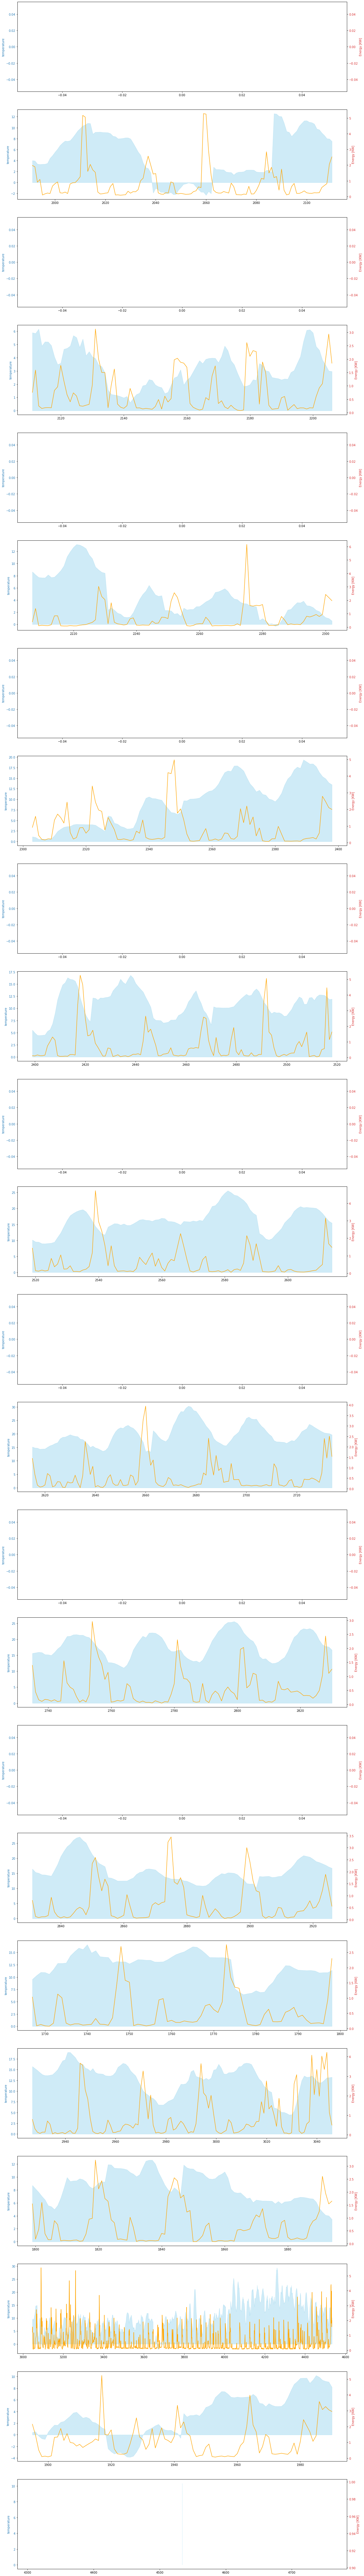

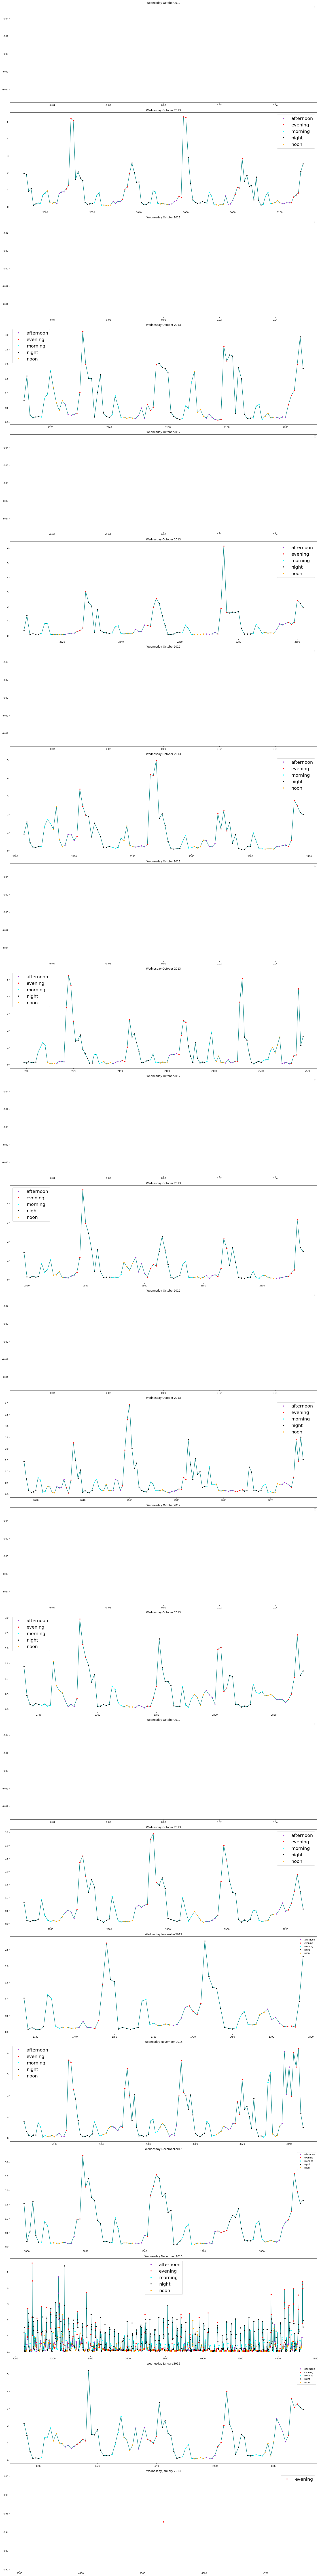

In [140]:
# plot consumption over different months for one household
ind1 = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].date.searchsorted(dt.date(day=1,month=1,year=2012), side='left')
ind2 = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].date.searchsorted(dt.date(day=1,month=1,year=2013), side='left')
# colors
color_dict = {
  "weekday": "blue",
  "weekend": "red",
  "holiday": "green"
}
color_dict_dp = {
  "morning": "cyan",
  "noon": "orange",
  "afternoon":"darkorchid",
  "evening": "red",
  "night":"black"
}
fig, axs = plt.subplots(24, 1, figsize=(20,20*8))
fff, xxx = plt.subplots(24, 1, figsize=(20,20*8))

for i in np.arange(1,13):
    if not i==12:
        ind1_next = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].date.searchsorted(dt.date(day=1,month=i+1,year=2012), side='left')
    else:
        ind1_next = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].date.searchsorted(dt.date(day=1,month=1,year=2013), side='left')
    df_temp = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].iloc[np.arange(ind1,ind1_next),:]
    # temperature
    ax1 = axs[2*(i-1)]
    color = 'tab:blue'
    ax1.set_ylabel('temperature', color=color) 
    ax1.fill_between(df_temp[df_temp['LCLid'] == 'MAC000246'].index, np.array(df_temp[df_temp['LCLid'] == 'MAC000246'].temperature.values, dtype=float),
                 color="skyblue", alpha=0.4)
    ax1.tick_params(axis='y', labelcolor=color)
    # energy
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_xlabel('Sample Number')
    ax2.set_ylabel('Energy [KW]', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.plot(df_temp[df_temp['LCLid'] == 'MAC000246'].index, df_temp[df_temp['LCLid'] == 'MAC000246'].energy, marker='', linestyle='-', ms=1, c='orange')
    ind1 = ind1_next
    # energy color by time
    xxx[2*(i-1)].plot(df_temp[df_temp['LCLid'] == 'MAC000246'].index, df_temp[df_temp['LCLid'] == 'MAC000246'].energy, marker='', linestyle='-', ms=1, c='teal')
    groups = df_temp[df_temp['LCLid'] == 'MAC000246'].groupby('daypart')
    for name, group in groups:
        xxx[2*(i-1)].plot(group.index, group.energy, marker='o', linestyle='', ms=4, label=name, c=color_dict_dp[name])
    xxx[2*(i-1)].legend()
    xxx[2*(i-1)].set_title('Wednesday' + ' '+ weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].date.iloc[ind1].strftime("%B") + '2012')
    
    
    
    # 2013
    if not i==12:
        ind2_next = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].date.searchsorted(dt.date(day=1,month=i+1,year=2013), side='left')
        df_temp = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].iloc[ind2:ind2_next,:]
    else:   
        df_temp = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].iloc[ind2:,:]
    # temperature
    ax1 = axs[2*i-1]
    color = 'tab:blue'
    ax1.set_ylabel('temperature', color=color)  
    ax1.fill_between(df_temp[df_temp['LCLid'] == 'MAC000246'].index, np.array(df_temp[df_temp['LCLid'] == 'MAC000246'].temperature.values, dtype=float),
                 color="skyblue", alpha=0.4)
    ax1.tick_params(axis='y', labelcolor=color)
    # energy
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_xlabel('Sample Number')
    ax2.set_ylabel('Energy [KW]', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    # connect all with narrow line
    ax2.plot(df_temp[df_temp['LCLid'] == 'MAC000246'].index, df_temp[df_temp['LCLid'] == 'MAC000246'].energy, marker='', linestyle='-', ms=1, c='orange')
    ind2 = ind2_next
    # energy color by time
    xxx[2*i-1].plot(df_temp[df_temp['LCLid'] == 'MAC000246'].index, df_temp[df_temp['LCLid'] == 'MAC000246'].energy, marker='', linestyle='-', ms=1, c='teal')
    groups = df_temp[df_temp['LCLid'] == 'MAC000246'].groupby('daypart')
    for name, group in groups:
        xxx[2*i-1].plot(group.index, group.energy, marker='o', linestyle='', ms=4, label=name, c=color_dict_dp[name])
    xxx[2*i-1].legend(fontsize=20)
    xxx[2*i-1].set_title('Wednesday' +' ' + weather_energy_info.date.iloc[ind1].strftime("%B") + ' '+'2013')
    
plt.tight_layout()
plt.show()

## Box plots

Text(0.5, 1.0, 'Day Parts Box Plot')

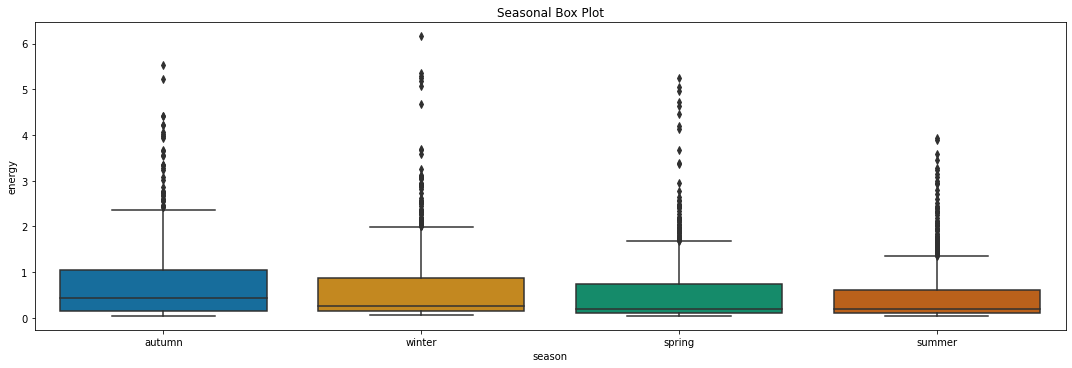

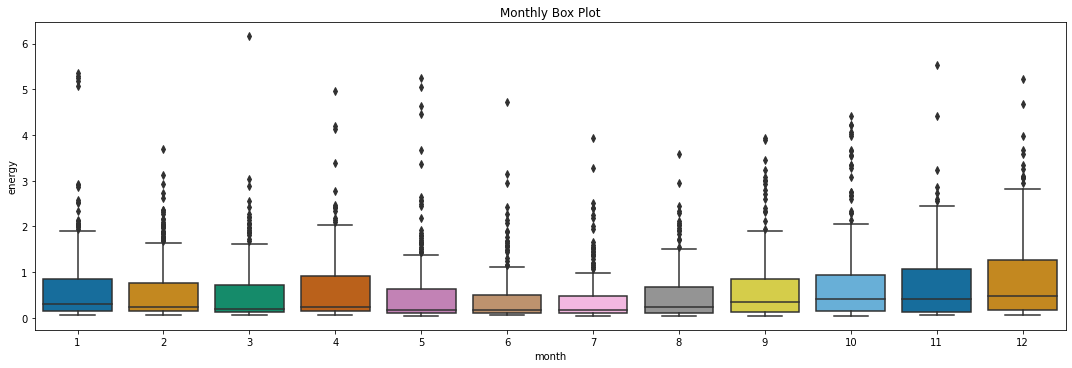

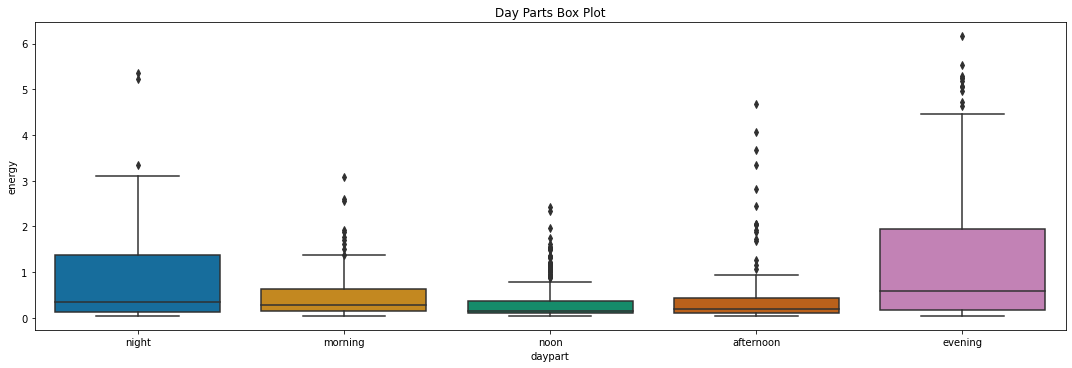

In [142]:
# Energy boxplots for one household

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y='energy', x='season', data=weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'], 
            palette="colorblind", 
            ax=ax)
plt.tight_layout()
ax.set_title('Seasonal Box Plot')

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y='energy', x='month', data=weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'], 
            palette="colorblind", 
            ax=ax)
plt.tight_layout()
ax.set_title('Monthly Box Plot')

fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y='energy', x='daypart', data=weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'], 
            palette="colorblind", 
            ax=ax)
plt.tight_layout()
ax.set_title('Day Parts Box Plot')



Text(0.5, 1.0, 'Hourly Box Plot Without Outliers')

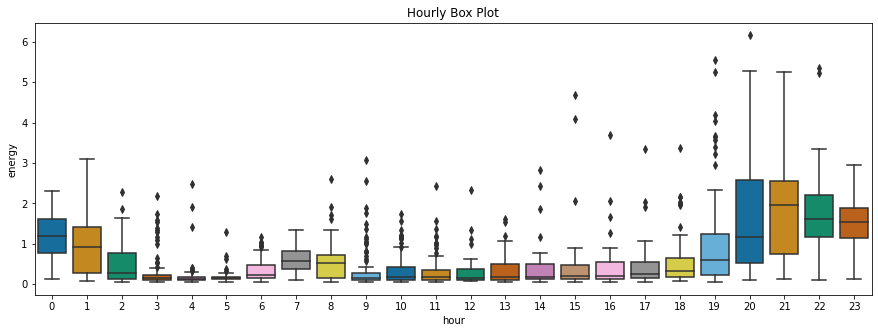

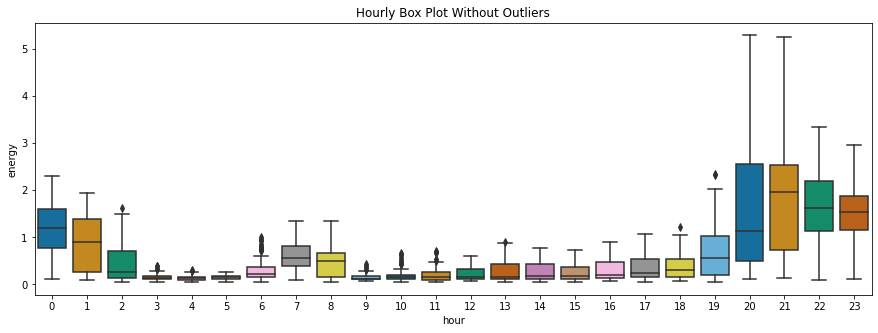

In [21]:
# box plots to check the effect of outlier cutting (skip this cell until model construction cells are run)
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y=y_train[1]['energy'], x='hour', data=X_train[1], 
            palette="colorblind", 
            ax=ax)
ax.set_title('Hourly Box Plot')
fig, ax = plt.subplots(figsize=(15,5))
sns.boxplot(y=y_train_filt[1], x='hour', data=X_train_filt[1], 
            palette="colorblind", 
            ax=ax)
ax.set_title('Hourly Box Plot Without Outliers')

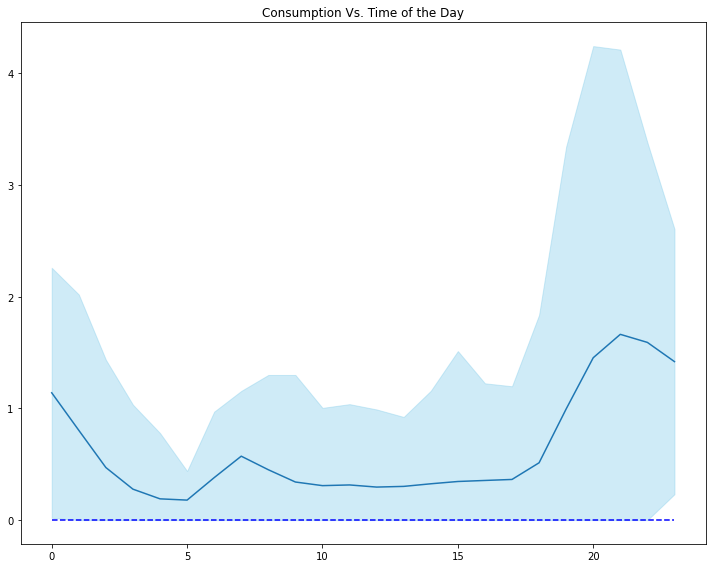

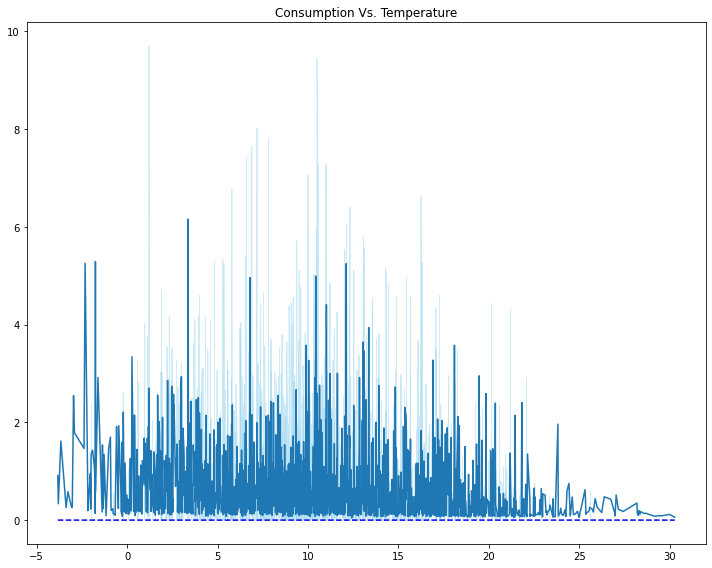

In [143]:
# dependencies of a household on different factors
fig, ax = plt.subplots(1,1,figsize=(10,8))
hours = np.arange(0,24,1)
horiz_line_data = np.zeros(24)

de_temp = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].copy()
means = de_temp.groupby('hour', as_index=False)['energy'].mean()
means = np.array(means.energy.values, dtype=float)
stds = de_temp.groupby('hour', as_index=False)['energy'].std()
stds = np.array(stds.energy.values, dtype=float)
# plot mean
ax.plot(hours, means)
# cnof bound
ax.fill_between(hours, means+1.96*stds, np.maximum(0,means-1.96*stds),
                 color="skyblue", alpha=0.4)
ax.plot(hours, horiz_line_data, 'b--') 
ax.set_title('Consumption Vs. Time of the Day')
ax1.set_ylabel('Energy [KW]')  
plt.tight_layout()

# temperature
fig, ax = plt.subplots(1,1,figsize=(10,8))
de_temp = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].copy()
means = de_temp.groupby('temperature', as_index=False)['energy'].mean()
temps = means.temperature.unique()
temps.sort()
horiz_line_data = np.zeros(len(temps))
means = np.array(means.energy.values, dtype=float)
stds = de_temp.groupby('temperature', as_index=False)['energy'].std()
stds = np.array(stds.energy.values, dtype=float)

# plot mean
ax.plot(temps, means)
# cnof bound
ax.fill_between(temps, means+1.96*stds, np.maximum(0,means-1.96*stds),
                 color="skyblue", alpha=0.4)
ax.plot(temps, horiz_line_data, 'b--') 
ax.set_title('Consumption Vs. Temperature')
ax1.set_ylabel('Energy [KW]')  
plt.tight_layout()

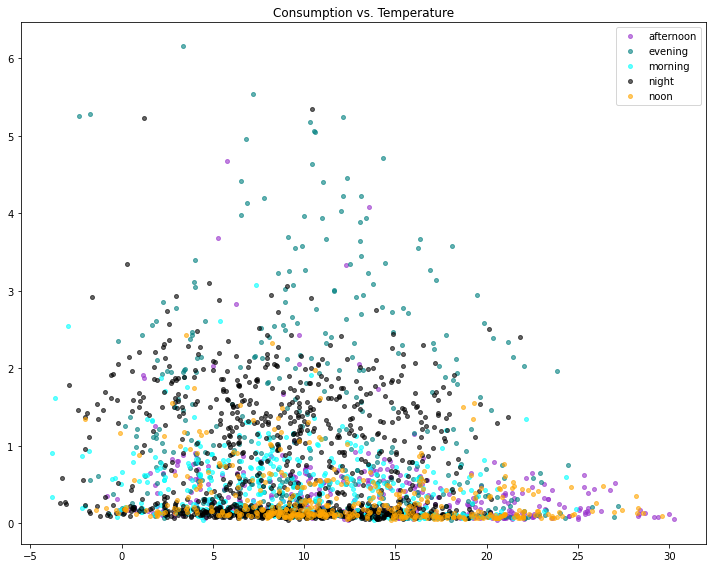

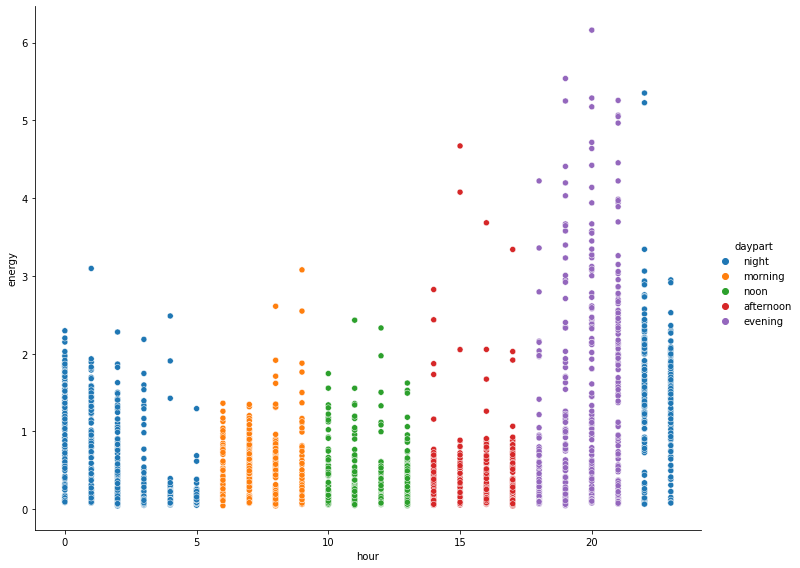

In [144]:
color_dict_dp = {
  "morning": "cyan",
  "noon": "orange",
  "afternoon":"darkorchid",
  "evening": "teal",
  "night":"black"
}
groups = weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].groupby('daypart')
fig, ax = plt.subplots(figsize=(10,8))
for name, group in groups:
    ax.plot(group.temperature, group.energy, marker='o', 
            linestyle='', ms=4, label=name, c=color_dict_dp[name],alpha=0.6)
    ax.legend()
    ax.set_title('Consumption vs. Temperature')
               
plt.tight_layout()
plt.show()



pp = sns.pairplot(weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'][['energy', 'hour','daypart']],
                  x_vars=['hour'], y_vars=['energy'],
                  height=8, aspect=1.25, hue = "daypart")

#fig = pp.fig() 

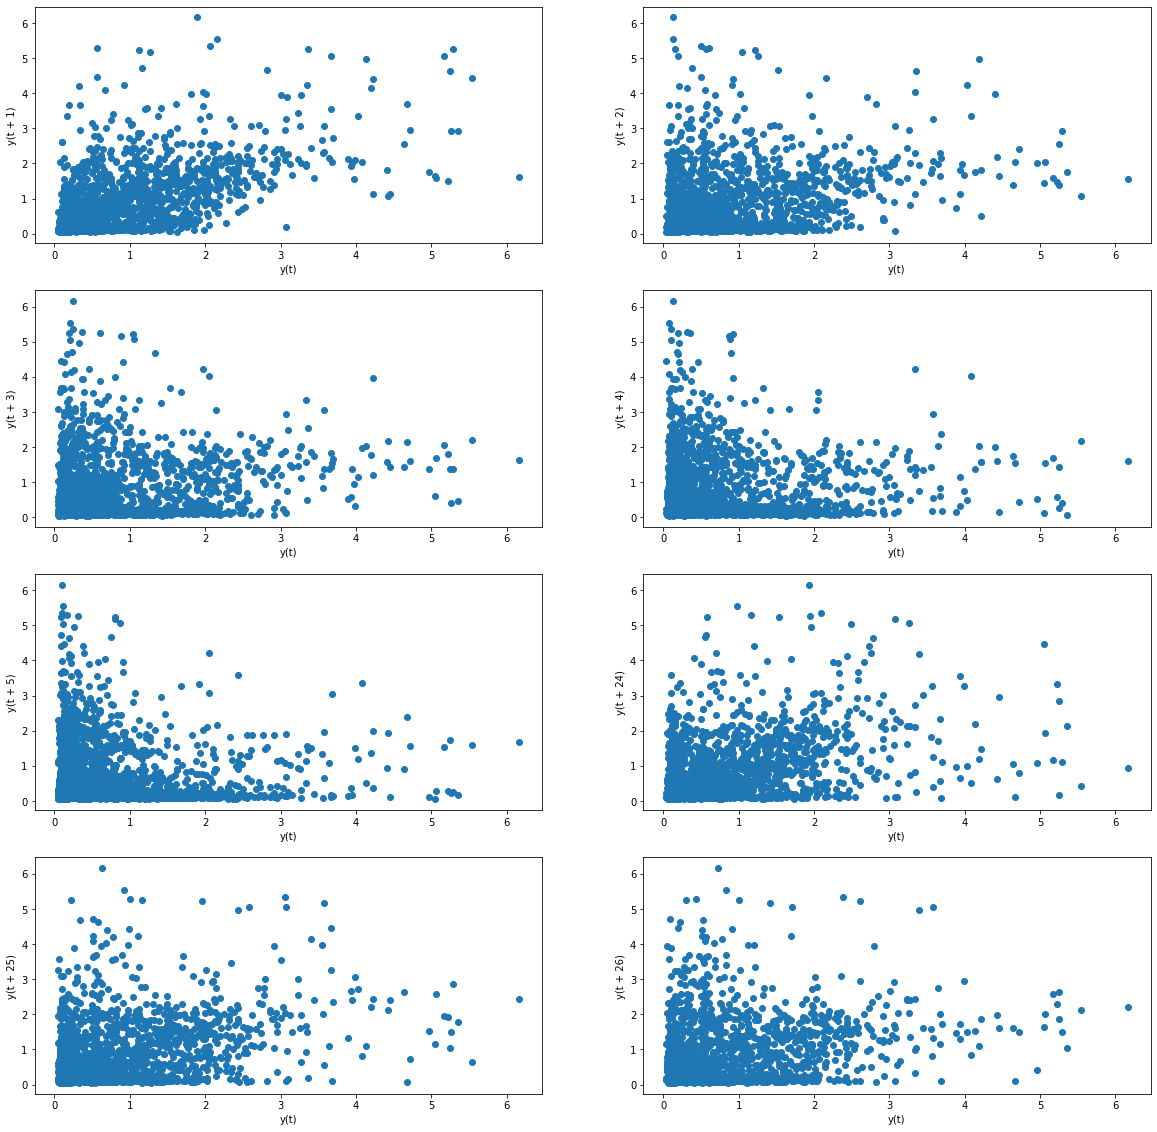

In [23]:
#lag plots for a specific household
lags = [1, 2, 3, 4, 5, 24, 25, 26]
fig, axs = plt.subplots(math.ceil(len(lags)/2), 2, figsize=(20,20))
color_dict_dp = {
  "morning": "cyan",
  "noon": "orange",
  "afternoon":"darkorchid",
  "evening": "teal",
  "night":"black"
}
for i, lag in enumerate(lags):
    #colors = [color_dict_dp[j] for j in df_1p.daypart.iloc[0:35089-lag]]
    pd.plotting.lag_plot(weather_energy_info[weather_energy_info['LCLid'] == 'MAC000246'].energy, lag=lag, ax=axs[int(i/2), int(i%2)])
    


# Cutting Outliers

In [2]:
def cut_outlier(df, target):
    df_temp = df.copy()
    target_temp = target.copy()
    df_temp['energy'] = target_temp
    df_temp['datetimes'] = df.index
    filter = pd.Series([])
    for i in range(24):
        Q1 = df_temp[df_temp['hour'] == i]['energy'].quantile(0.25)
        Q3 = df_temp[df_temp['hour'] == i]['energy'].quantile(0.75)
        IQR = Q3 - Q1    #IQR is interquartile range. 
        filter = filter.append((df_temp[df_temp['hour'] == i]['energy'] >= Q1 - 1.5 * IQR) & (df_temp[df_temp['hour'] == i]['energy'] <= Q3 + 1.5 *IQR))
    filter.sort_index(ascending=True, inplace = True)
    df_temp = df_temp.loc[filter]
    df_temp.reset_index(inplace = True)
    df_temp.set_index(['datetimes'],inplace=True)
    target_temp = df_temp['energy']
    df_temp.drop(columns = 'energy', inplace = True)
    df_temp.drop(columns = ['datetime'], inplace = True)
    return df_temp, target_temp

# Automated Feature selection

In [25]:
# putting time in a sinusoidal function (solely for feature selection purposes)
weather_energy_info['hourofd_x'] = np.sin(weather_energy_info['time']/24*2*math.pi)
weather_energy_info['hourofd_y'] = np.cos(weather_energy_info['time']/24*2*math.pi)

In [26]:
# fitting KBest algorithm to get an indication of most important features
features = list(set(list(weather_energy_info.columns)) - set(['energy', 'daypart', 'season', 'weekday', 'stdorToU', 'tstp', 'Acorn','Acorn_grouped', 'datetime','date', 'Bank holidays', 'Type', 'LCLid', 'hour', 'apparentTemperature']))
X = weather_energy_info.loc[:, features]
Y = weather_energy_info['energy']
KBest = SelectKBest(score_func = f_regression, k = 24) #f_regression criterion selected
KBest = KBest.fit(X,Y)
df_scores = pd.DataFrame({'features': X.columns, 'Mutual_info': KBest.scores_, 'pValue': KBest.pvalues_ })
df_scores

C:\Users\denis\Anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:302: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


features    Mutual_info         pValue
0          lag24  115227.765245   0.000000e+00
1           lag4   54653.104633   0.000000e+00
2      hourofd_y      47.324949   6.055580e-12
3    holiday_ind      49.182707   2.349290e-12
4     visibility      19.384727   1.069884e-05
5            ld2   85148.168510   0.000000e+00
6   day_of_month       0.576296   4.477700e-01
7          index     712.688922  2.308654e-156
8           lag3   75035.041667   0.000000e+00
9    windBearing       7.217754   7.220001e-03
10          time    4398.393473   0.000000e+00
11      dewPoint     348.806416   1.103853e-77
12      dayofy_y     629.402301  2.157121e-138
13           ld3   63903.666787   0.000000e+00
14   temperature     256.723982   1.079655e-57
15          lag2  113678.200065   0.000000e+00
16        minute            NaN            NaN
17      dayofy_x       0.003947   9.499050e-01
18  flag_weekend            NaN            NaN
19        dayofy       9.034129   2.650625e-03
20          lag5   42850.579584   0.000000e+00
21       level_0     712.690947  2.306334e-156
22          lag1  245459.566461   0.000000e+00
23      humidity       8.721532   3.145597e-03
24     windSpeed     288.811323   1.155008e-64
25           ld1  120378.124277   0.000000e+00
26           ld0  156922.265295   0.000000e+00
27     time_conv    4398.393473   0.000000e+00
28      pressure     111.157838   5.669945e-26
29         lag25   93505.733497   0.000000e+00
30     hourofd_x    3217.412095   0.000000e+00
31         month       8.456055   3.639241e-03
32         lag26   67975.239331   0.000000e+00

In [27]:
# get column indexes
cols = KBest.get_support(indices=True)
cols

array([ 0,  1,  2,  3,  5,  7,  8, 10, 11, 12, 13, 14, 15, 20, 21, 22, 24,
       25, 26, 27, 28, 29, 30, 32], dtype=int64)

In [28]:
# get column names
features = X.columns[cols]
features

Index(['lag24', 'lag4', 'hourofd_y', 'holiday_ind', 'ld2', 'index', 'lag3',
       'time', 'dewPoint', 'dayofy_y', 'ld3', 'temperature', 'lag2', 'lag5',
       'level_0', 'lag1', 'windSpeed', 'ld1', 'ld0', 'time_conv', 'pressure',
       'lag25', 'hourofd_x', 'lag26'],
      dtype='object')

# Model construction

In [166]:
# setting datetime as index
weather_energy_info.set_index(['datetime'],inplace=True)
weather_energy_info.head()

In [853]:
# saving preprocessed dataframe to pickle
weather_energy_info.to_pickle("data/weather_energy_info.pkl", compression='bz2')

In [102]:
# loading preprocessed dataframes from pickle and initializing needed variables
weather_energy_info = pd.read_pickle("data/weather_energy_info.pkl",compression='bz2')
weather_energy = pd.read_pickle("data/weather_energy.pkl",compression='bz2')
uniqueValues = weather_energy_info['LCLid'].unique()

In [103]:
# splitting main dataframe into a list of dataframes based on house id
ds = []
for i in uniqueValues:
    ds.append(weather_energy_info[weather_energy_info['LCLid']== i])

In [29]:
# splitting into x and y, with needed features for x
model_data_x = []
model_data_y = []
for i in range(len(ds)):
    model_data_x.append(ds[i][['hour','minute','temperature','pressure','holiday_ind', 'lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag24', 'lag25', 'lag26','ld0', 'ld1', 'ld2', 'ld3', 'windSpeed', 'dayofy_y', 'daypart']])
    model_data_y.append(ds[i][['energy']])

In [30]:
# setting a fraction for train/test split
fraction = 0.75

In [31]:
# train/test split (needs to be done manually to conserve time series continuity)
X_train = []
y_train = []
X_test = []
y_test = []
for i in range(len(ds)):
    X_train.append(model_data_x[i][26:int(fraction*len(model_data_x[i]))])
    y_train.append(model_data_y[i][26:int(fraction*len(model_data_y[i]))])
    X_test.append(model_data_x[i][int(fraction*len(model_data_x[i])):])
    y_test.append(model_data_y[i][int(fraction*len(model_data_x[i])):])

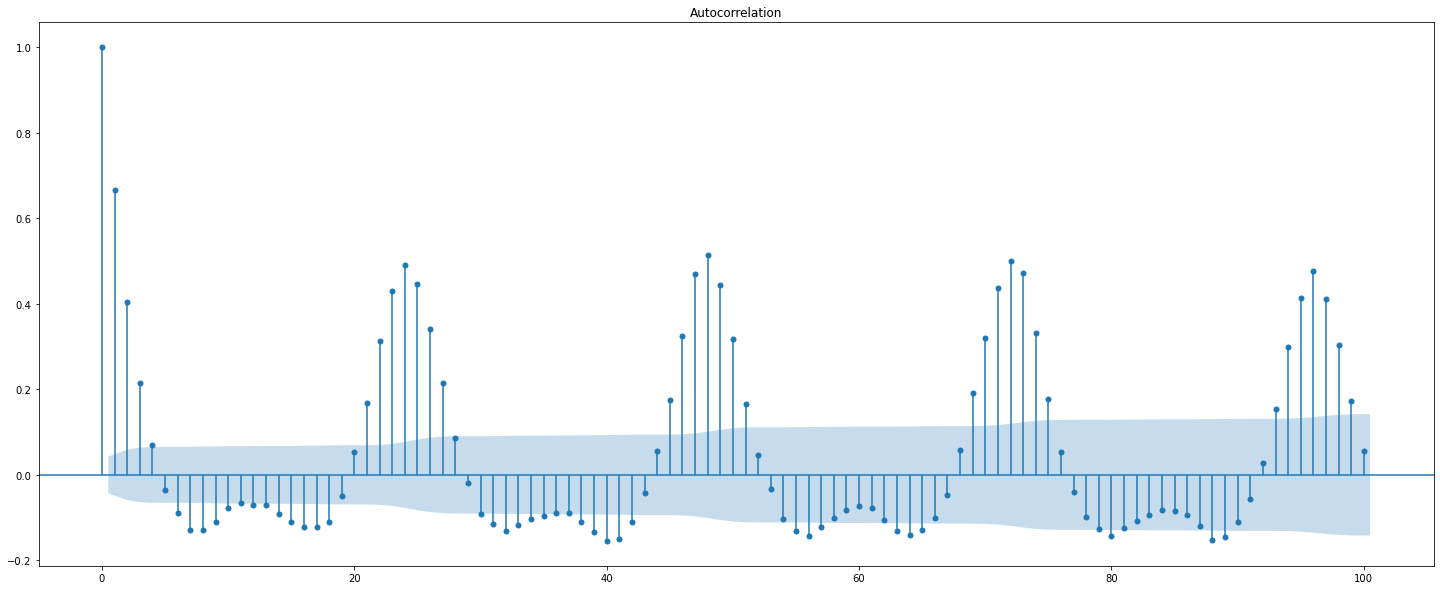

In [32]:
# autocorrelation plot
fig, ax = plt.subplots(figsize=(25, 10))
plot_acf(y_train[1].energy,lags=100, ax = ax)
plt.show()

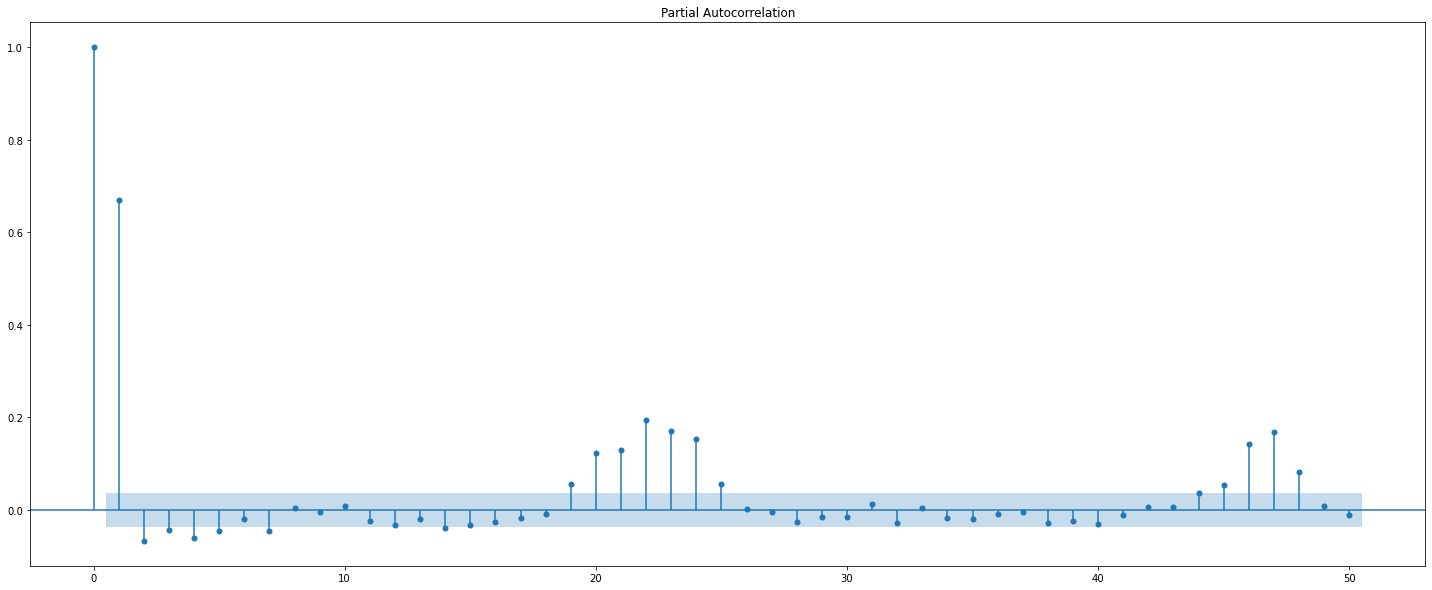

In [33]:
# partial autocorrelation plot
fig, ax = plt.subplots(figsize=(25, 10))
plot_pacf(model_data_y[1].energy,lags=50, ax = ax)
plt.show()

In [34]:
#Dickey Fuller Test (stationarity test)
t = sm.tsa.adfuller(model_data_y[1].energy, autolag='AIC')
pd.Series(t[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

Test Statistic                   -4.969156
p-value                           0.000026
#Lags Used                       24.000000
Number of Observations Used    2783.000000
dtype: float64

In [35]:
# changing DateTimeIndex to period of 1 hour
for i in range(len(ds)):    
    X_train[i].index = pd.DatetimeIndex(X_train[i].index).to_period('60T')
    X_test[i].index = pd.DatetimeIndex(X_test[i].index).to_period('60T')
    y_train[i].index = pd.DatetimeIndex(y_train[i].index).to_period('60T')
    y_test[i].index = pd.DatetimeIndex(y_test[i].index).to_period('60T')

In [36]:
# converting time into a float representation of time (5:30->5.5)
for i in range(len(ds)):   
    X_train[i]['time'] = X_train[i]['hour'] + X_train[i]['minute']/60
    X_test[i]['time'] = X_test[i]['hour'] + X_test[i]['minute']/60

C:\Users\denis\AppData\Local\Temp/ipykernel_7332/1611360047.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i]['time'] = X_train[i]['hour'] + X_train[i]['minute']/60
C:\Users\denis\AppData\Local\Temp/ipykernel_7332/1611360047.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[i]['time'] = X_test[i]['hour'] + X_test[i]['minute']/60


In [37]:
# putting time in a sinusoidal function 
for i in range(len(ds)):   
    X_train[i]['hourofd_x'] = np.sin(X_train[i]['time']/24*2*math.pi)
    X_train[i]['hourofd_y'] = np.cos(X_train[i]['time']/24*2*math.pi)
    X_test[i]['hourofd_x'] = np.sin(X_test[i]['time']/24*2*math.pi)
    X_test[i]['hourofd_y'] = np.cos(X_test[i]['time']/24*2*math.pi)

C:\Users\denis\AppData\Local\Temp/ipykernel_7332/2028261343.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i]['hourofd_x'] = np.sin(X_train[i]['time']/24*2*math.pi)
C:\Users\denis\AppData\Local\Temp/ipykernel_7332/2028261343.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i]['hourofd_y'] = np.cos(X_train[i]['time']/24*2*math.pi)
C:\Users\denis\AppData\Local\Temp/ipykernel_7332/2028261343.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

In [38]:
# Label Encoding dayparts
le = preprocessing.LabelEncoder()
for i in range(len(ds)): 
    X_train[i]['daypart'] = le.fit_transform(X_train[i]['daypart'])
    X_test[i]['daypart'] = le.fit_transform(X_test[i]['daypart'])

C:\Users\denis\AppData\Local\Temp/ipykernel_7332/547299480.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[i]['daypart'] = le.fit_transform(X_train[i]['daypart'])
C:\Users\denis\AppData\Local\Temp/ipykernel_7332/547299480.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[i]['daypart'] = le.fit_transform(X_test[i]['daypart'])


In [39]:
# Cutting outliers only in train data(create new dataframe for experimentation)
X_train_no_out = []
y_train_no_out = []
for i in range(len(ds)): 
    out_x, out_y = cut_outlier(X_train[i], y_train[i])
    X_train_no_out.append(out_x)
    y_train_no_out.append(out_y)

C:\Users\denis\AppData\Local\Temp/ipykernel_7332/3300090591.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filter = pd.Series([])


In [40]:
# Cutting outliers in all data
model_no_out = []
output_test_no_out = []
for i in range(len(ds)): 
    x_out, y_out = cut_outlier(model_data_x[i][26:], model_data_y[i][26:])
    model_no_out.append(x_out)
    output_test_no_out.append(y_out)

C:\Users\denis\AppData\Local\Temp/ipykernel_7332/3300090591.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  filter = pd.Series([])


In [41]:
# splitting into train/test sets of the model with no outliers and preprocessing
X_train_filt = []
y_train_filt = []
X_test_filt = []
y_test_filt = []
for i in range(len(ds)): 
    X_train_filt.append(model_no_out[i][:int(fraction*len(model_no_out[i]))])
    y_train_filt.append(output_test_no_out[i][:int(fraction*len(output_test_no_out[i]))])
    X_test_filt.append(model_no_out[i][int(fraction*len(model_no_out[i])):])
    y_test_filt.append(output_test_no_out[i][int(fraction*len(output_test_no_out[i])):])
for i in range(len(ds)): 
    X_train_filt[i].index = pd.DatetimeIndex(X_train_filt[i].index).to_period('60T')
    X_test_filt[i].index = pd.DatetimeIndex(X_test_filt[i].index).to_period('60T')
    y_train_filt[i].index = pd.DatetimeIndex(y_train_filt[i].index).to_period('60T')
    y_test_filt[i].index = pd.DatetimeIndex(y_test_filt[i].index).to_period('60T')

    X_train_filt[i]['time'] = X_train_filt[i]['hour'] + X_train_filt[i]['minute']/60
    X_test_filt[i]['time'] = X_test_filt[i]['hour'] + X_test_filt[i]['minute']/60

    X_train_filt[i]['hourofd_x'] = np.sin(X_train_filt[i]['time']/24*2*math.pi)
    X_train_filt[i]['hourofd_y'] = np.cos(X_train_filt[i]['time']/24*2*math.pi)

    X_test_filt[i]['hourofd_x'] = np.sin(X_test_filt[i]['time']/24*2*math.pi)
    X_test_filt[i]['hourofd_y'] = np.cos(X_test_filt[i]['time']/24*2*math.pi)

    X_train_filt[i]['daypart'] = le.fit_transform(X_train_filt[i]['daypart'])
    X_test_filt[i]['daypart'] = le.fit_transform(X_test_filt[i]['daypart'])

C:\Users\denis\AppData\Local\Temp/ipykernel_7332/1196428038.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_filt[i]['time'] = X_train_filt[i]['hour'] + X_train_filt[i]['minute']/60
C:\Users\denis\AppData\Local\Temp/ipykernel_7332/1196428038.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_filt[i]['time'] = X_test_filt[i]['hour'] + X_test_filt[i]['minute']/60
C:\Users\denis\AppData\Local\Temp/ipykernel_7332/1196428038.py:20: SettingWithCopyWarning: 
A value is trying to be set on a co

In [445]:
# scaling of the data
sc = StandardScaler()
X_train_sc = []
X_test_sc = []
X_train_no_out_sc = []
X_train_filt_sc = []
X_test_filt_sc = []
# following loops are needed due to data types returned by standard scaler
for i in range(len(ds)): 
    X_train_sc.append(sc.fit_transform(X_train[i]))
    X_test_sc.append(sc.fit_transform(X_test[i]))
    X_train_no_out_sc.append(sc.fit_transform(X_train_no_out[i]))
    X_train_filt_sc.append(sc.fit_transform(X_train_filt[i]))
    X_test_filt_sc.append(sc.fit_transform(X_test_filt[i]))
for i in range(len(ds)): 
    X_train[i] = pd.DataFrame(X_train_sc[i], index=X_train[i].index, columns=X_train[i].columns)
    X_test[i] = pd.DataFrame(X_test_sc[i], index=X_test[i].index, columns=X_test[i].columns)
    X_train_no_out[i] = pd.DataFrame(X_train_no_out_sc[i], index=X_train_no_out[i].index, columns=X_train_no_out[i].columns)
    X_train_filt[i] = pd.DataFrame(X_train_filt_sc[i], index=X_train_filt[i].index, columns=X_train_filt[i].columns)
    X_test_filt[i] = pd.DataFrame(X_test_filt_sc[i], index=X_test_filt[i].index, columns=X_test_filt[i].columns)

# Models (for single household)

## Linear Regression

In [486]:
# fitting Linear Regression
lr_fit = LinearRegression(n_jobs = -1).fit(X_train[1], y_train[1])
lrscore = lr_fit.score(X_train[1], y_train[1])
print(lrscore)

0.5523626291752882


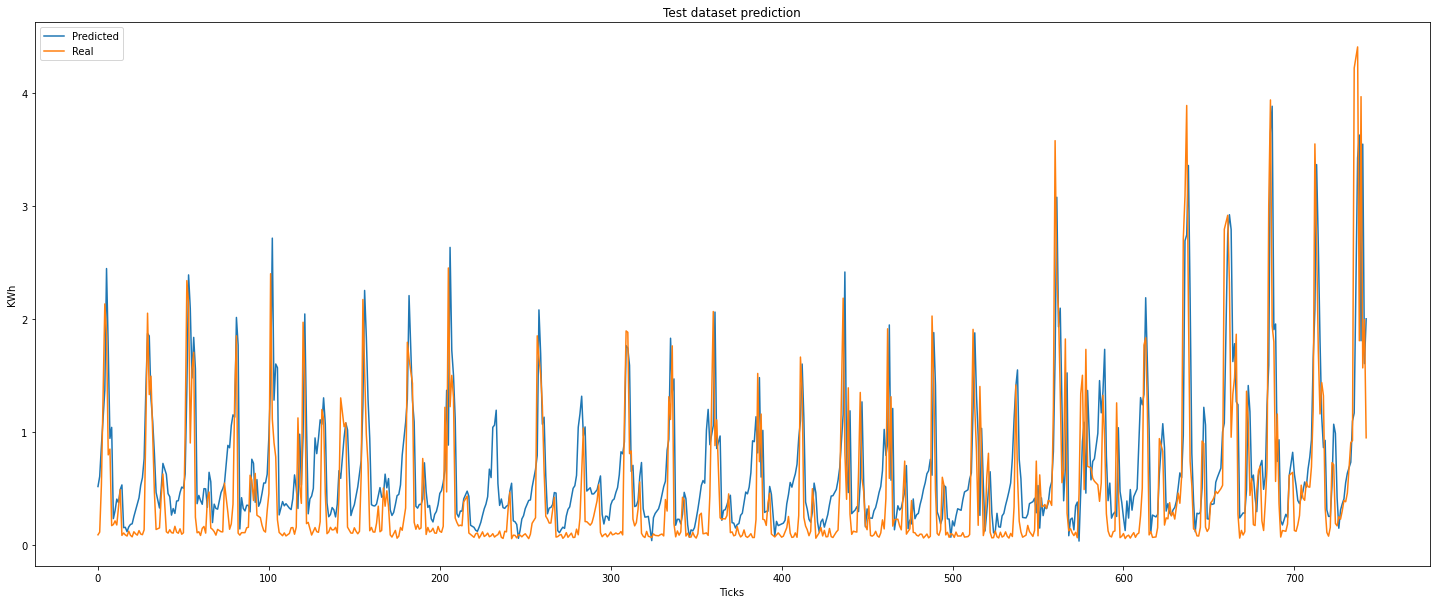

In [487]:
# fitting on test data and plotting result
plt.figure(figsize = (25,10))
predictions_lr = lr_fit.predict(X_test[1])
for i in range(len(predictions_lr)):
    if predictions_lr[i] < 0:
        predictions_lr[i] = 0
plt.plot(weather_energy.index[:len(y_test[1])], predictions_lr, label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test[1])],y_test[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

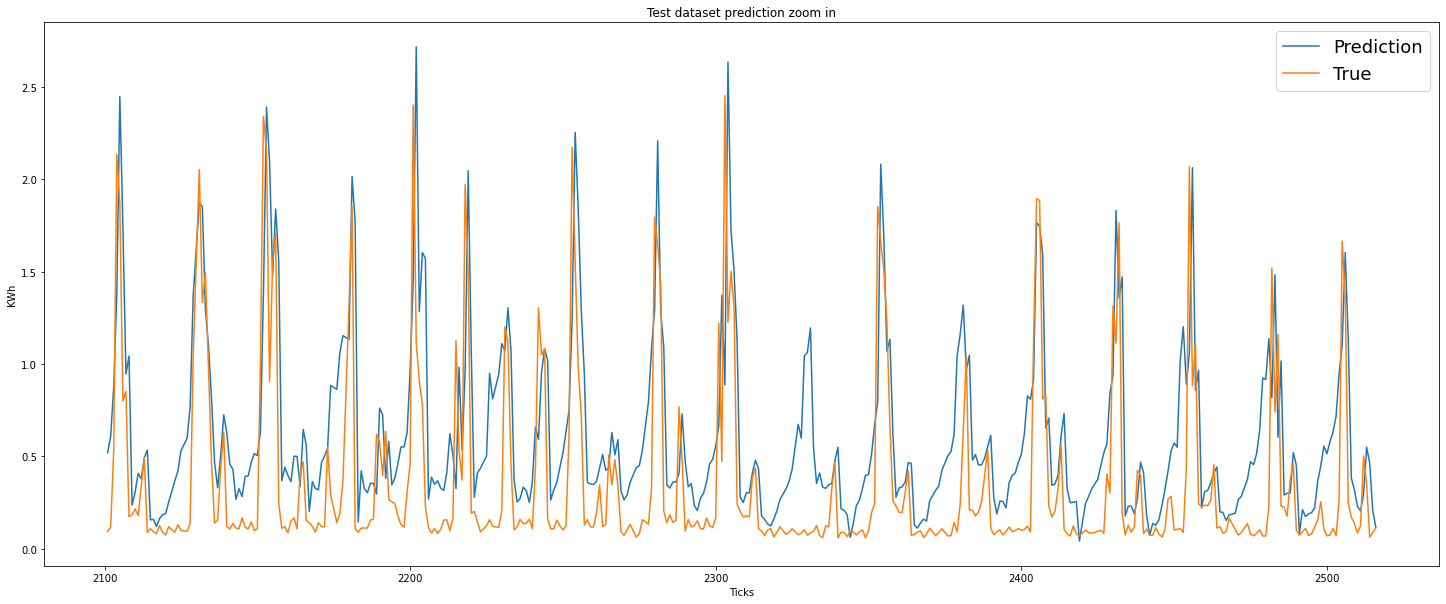

In [488]:
# plotting zoomed in version
plt.figure(figsize = (25,10))
plt.plot(weather_energy.index[2000:2400], predictions_lr[:400], label = 'Prediction')
plt.plot(weather_energy.index[2000:2400],y_test[1][:400], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend(fontsize = 18, loc = 0)

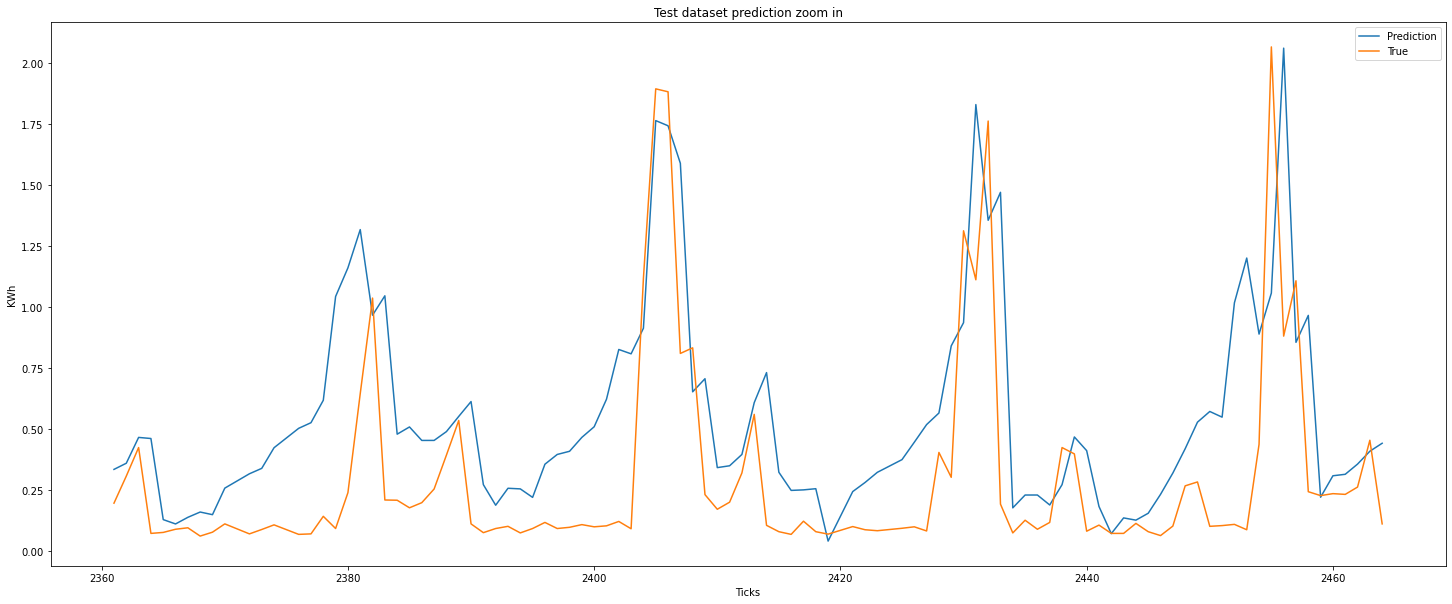

In [489]:
# zoomning even more
plt.figure(figsize = (25,10))
plt.plot(weather_energy.index[2250:2350], predictions_lr[250:350], label = 'Prediction')
plt.plot(weather_energy.index[2250:2350],y_test[1][250:350], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [490]:
# Metrics: MSE, R2, MAE, MDA
test_score_lr = mean_squared_error(y_test[1], predictions_lr)
print('Test MSE: %.3f' % test_score_lr)

Test MSE: 0.272


In [491]:
r2_score(y_test[1], predictions_lr)

0.3690329874475059

In [492]:
mda(np.asarray(y_test[1]), predictions_lr)

0.5320970042796006

In [493]:
test_score_mae = mean_absolute_error(y_test[1], predictions_lr)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.372


### No outliers in train data

In [494]:
# fitting Linear Regression
lr_fit = LinearRegression(n_jobs = -1).fit(X_train_no_out[1], y_train_no_out[1])
lrscore = lr_fit.score(X_train_no_out[1], y_train_no_out[1])
print(lrscore)

0.6158157092216449


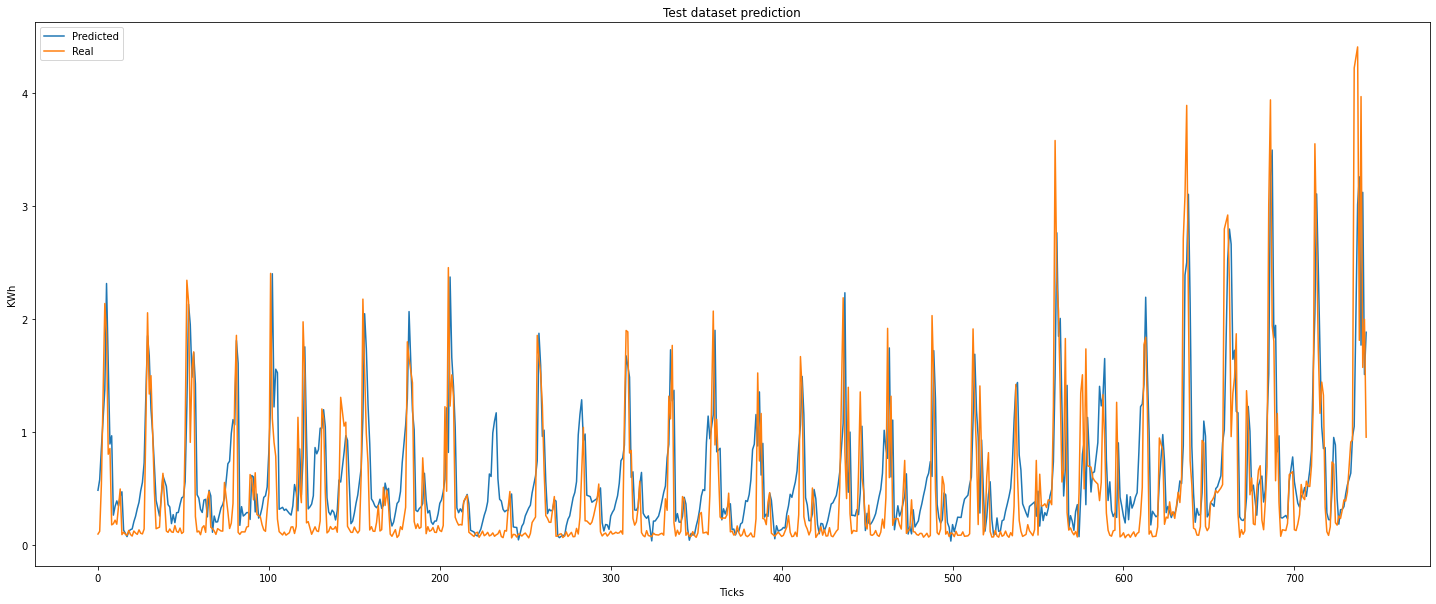

In [495]:
# fitting on test data and plotting result
plt.figure(figsize = (25,10))
predictions_lr = lr_fit.predict(X_test[1])
for i in range(len(predictions_lr)):
    if predictions_lr[i] < 0:
        predictions_lr[i] = 0
plt.plot(weather_energy.index[:len(y_test[1])], predictions_lr, label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test[1])],y_test[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [496]:
# Metrics: MSE, R2, MAE, MDA
test_score_lr = mean_squared_error(y_test[1], predictions_lr)
print('Test MSE: %.3f' % test_score_lr)

Test MSE: 0.239


In [497]:
r2_score(y_test[1], predictions_lr)

0.445189332908818

In [498]:
mda(np.asarray(y_test[1]), predictions_lr)

0.49757733500745827

In [499]:
test_score_mae = mean_absolute_error(y_test[1], predictions_lr)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.331


### No outliers in all data

In [500]:
# fitting Linear Regression
lr_fit = LinearRegression(n_jobs = -1).fit(X_train_filt[1], y_train_filt[1])
lrscore = lr_fit.score(X_train_filt[1], y_train_filt[1])
print(lrscore)

0.6187170637284285


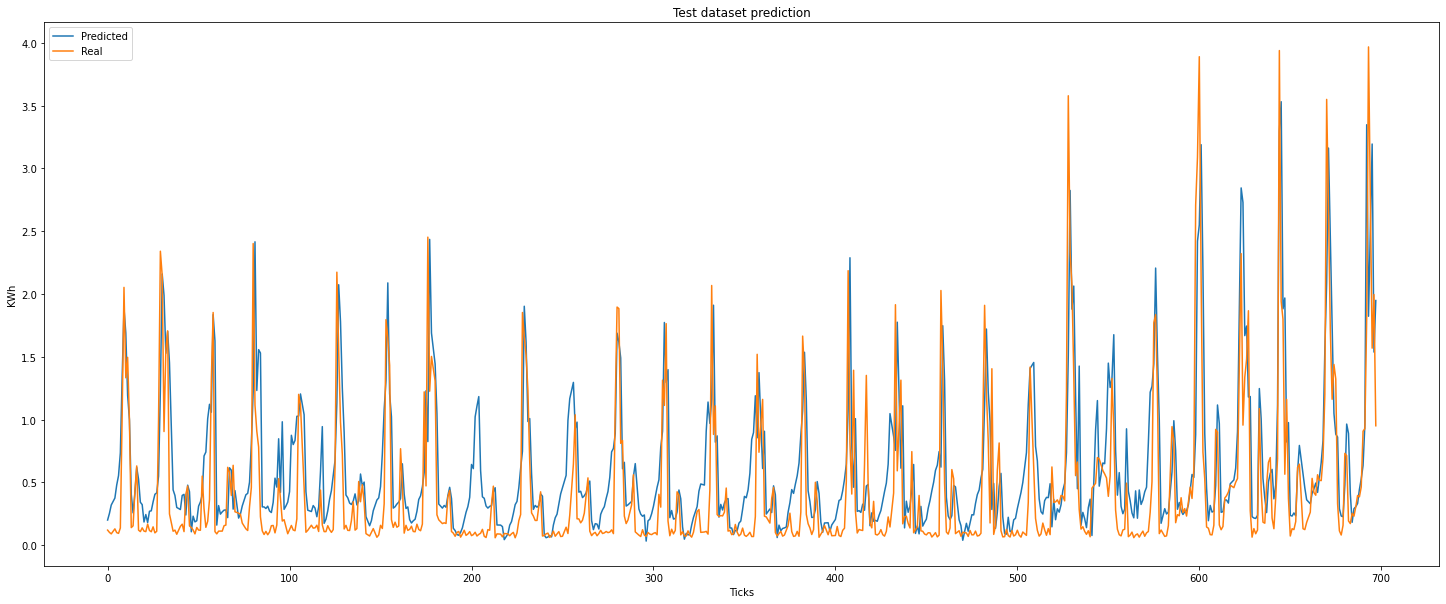

In [501]:
# fitting on test data and plotting result
plt.figure(figsize = (25,10))
predictions_lr = lr_fit.predict(X_test_filt[1])
for i in range(len(predictions_lr)):
    if predictions_lr[i] < 0:
        predictions_lr[i] = 0
plt.plot(weather_energy.index[:len(y_test_filt[1])], predictions_lr, label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test_filt[1])],y_test_filt[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [502]:
# Metrics: MSE, R2, MAE, MDA
test_score_lr = mean_squared_error(y_test_filt[1], predictions_lr)
print('Test MSE: %.3f' % test_score_lr)

Test MSE: 0.214


In [503]:
r2_score(y_test_filt[1], predictions_lr)

0.40115305844893856

In [504]:
mda(np.asarray(y_test_filt[1]), predictions_lr)

0.5447647951441578

In [505]:
test_score_mae = mean_absolute_error(y_test_filt[1], predictions_lr)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.319


## SVR 

In [506]:
# fitting SVR
svr_fit = svm.NuSVR(kernel='poly', degree = 1,C = 0.1, nu = 0.7).fit(X_train[1], y_train[1])
svrscore = svr_fit.score(X_train[1], y_train[1])
print(svrscore)

C:\Users\denis\Anaconda3\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


0.514148439612875


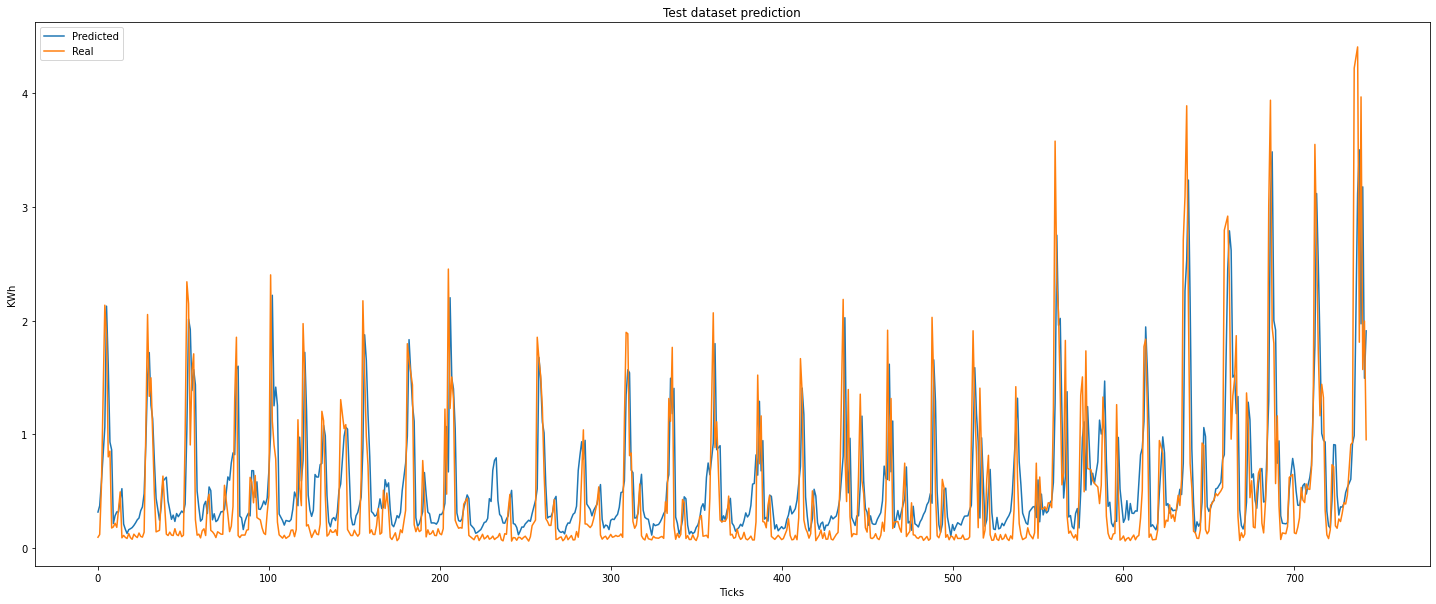

In [507]:
# fitting on test data and plotting result
plt.figure(figsize = (25,10))
predictions_svr = svr_fit.predict(X_test[1])
for i in range(len(predictions_svr)):
    if predictions_svr[i] < 0:
        predictions_svr[i] = 0
plt.plot(weather_energy.index[:len(y_test[1])], predictions_svr, label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test[1])],y_test[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

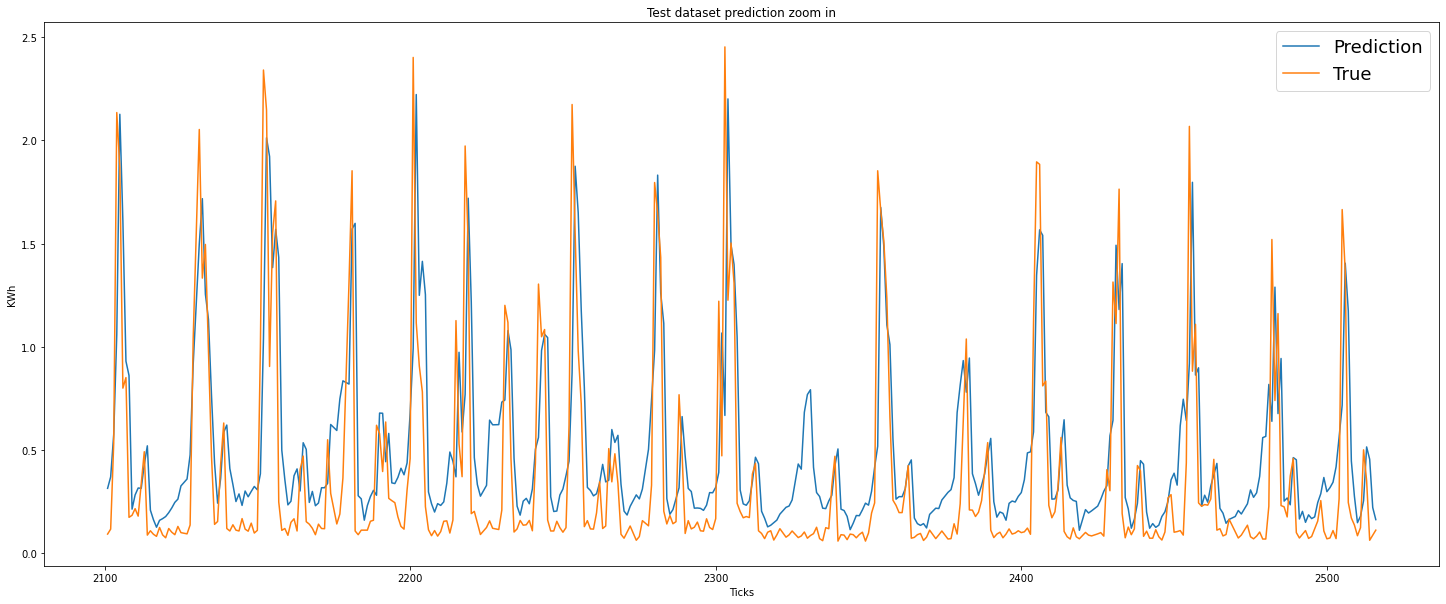

In [508]:
# plotting zoomed in version
plt.figure(figsize = (25,10))
plt.plot(weather_energy.index[2000:2400], predictions_svr[:400], label = 'Prediction')
plt.plot(weather_energy.index[2000:2400],y_test[1][:400], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend(fontsize = 18, loc = 0)

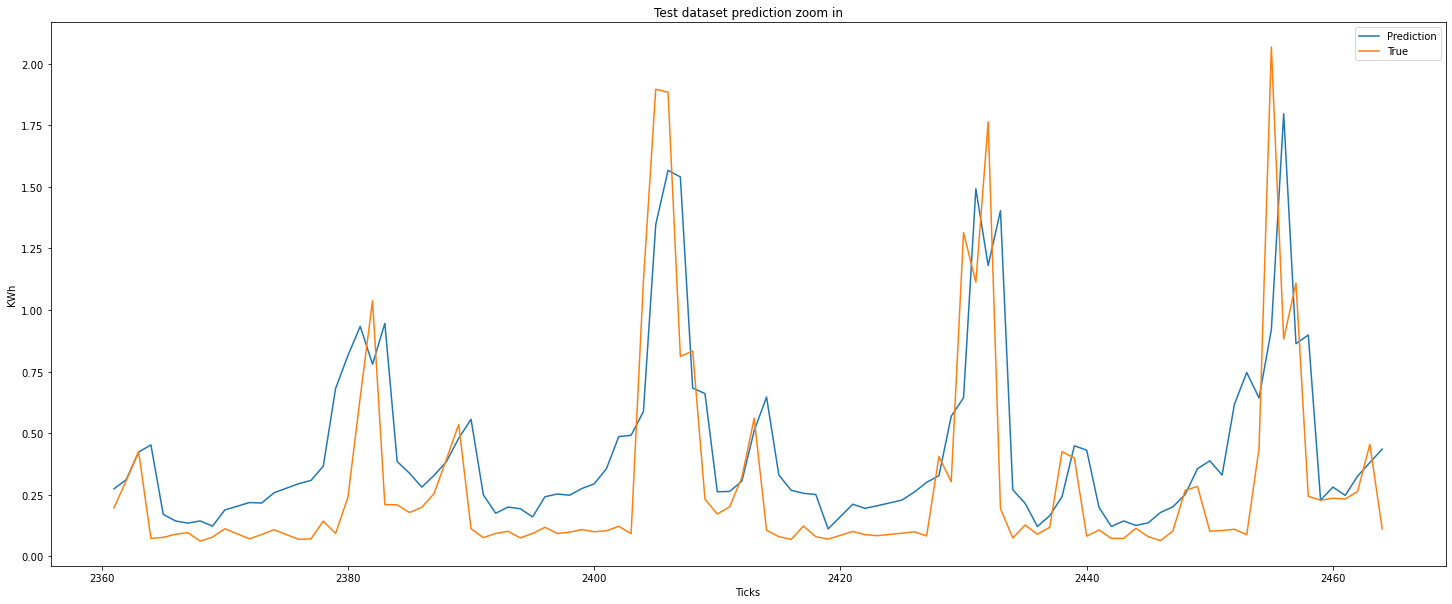

In [509]:
# zoomning even more
plt.figure(figsize = (25,10))
plt.plot(weather_energy.index[2250:2350], predictions_svr[250:350], label = 'Prediction')
plt.plot(weather_energy.index[2250:2350],y_test[1][250:350], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [510]:
# Metrics: MSE, R2, MAE, MDA
test_score_svr = mean_squared_error(y_test[1], predictions_svr)
print('Test MSE: %.3f' % test_score_svr)

Test MSE: 0.229


In [511]:
r2_score(y_test[1], predictions_svr)

0.46838176773685725

In [512]:
mda(np.asarray(y_test[1]), predictions_svr)

0.4974369201527876

In [513]:
test_score_mae = mean_absolute_error(y_test[1], predictions_svr)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.310


### No outliers in train data

In [562]:
# same order of procedures as above
svr_fit = svm.NuSVR(kernel='poly', degree = 1,C = 0.1, nu = 0.5).fit(X_train_no_out[1], y_train_no_out[1])
svrscore = svr_fit.score(X_train_no_out[1], y_train_no_out[1])
print(svrscore)

0.5906562345784225


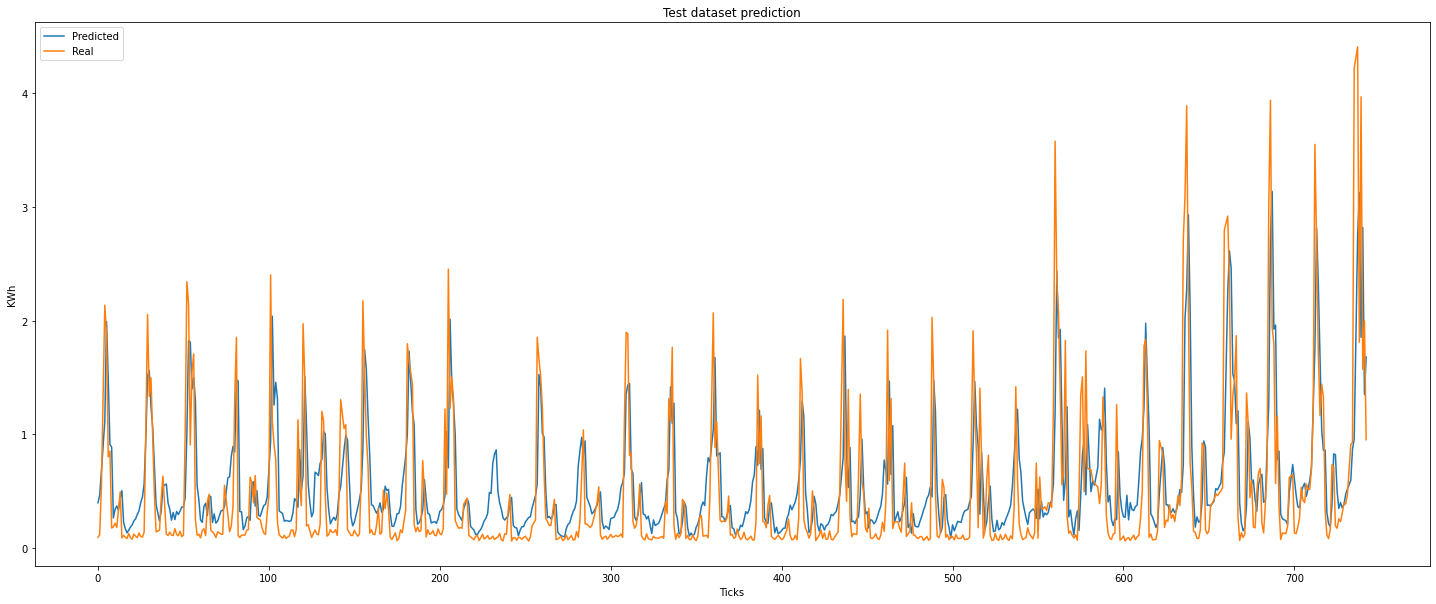

In [563]:
plt.figure(figsize = (25,10))
predictions_svr = svr_fit.predict(X_test[1])
for i in range(len(predictions_svr)):
    if predictions_svr[i] < 0:
        predictions_svr[i] = 0
plt.plot(weather_energy.index[:len(y_test[1])], predictions_svr, label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test[1])],y_test[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [564]:
test_score_svr = mean_squared_error(y_test[1], predictions_svr)
print('Test MSE: %.3f' % test_score_svr)

Test MSE: 0.222


In [565]:
r2_score(y_test[1], predictions_svr)

0.48507827208603305

In [566]:
mda(np.asarray(y_test[1]), predictions_svr)

0.49747355011487565

In [567]:
test_score_mae = mean_absolute_error(y_test[1], predictions_svr)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.308


### No outliers in all data

In [571]:
# same order of procedure as above
svr_fit = svm.NuSVR(kernel='poly', degree = 1,C = 0.1, nu = 0.7).fit(X_train_filt[1], y_train_filt[1])
svrscore = svr_fit.score(X_train_filt[1], y_train_filt[1])
print(svrscore)

0.5904306731702986


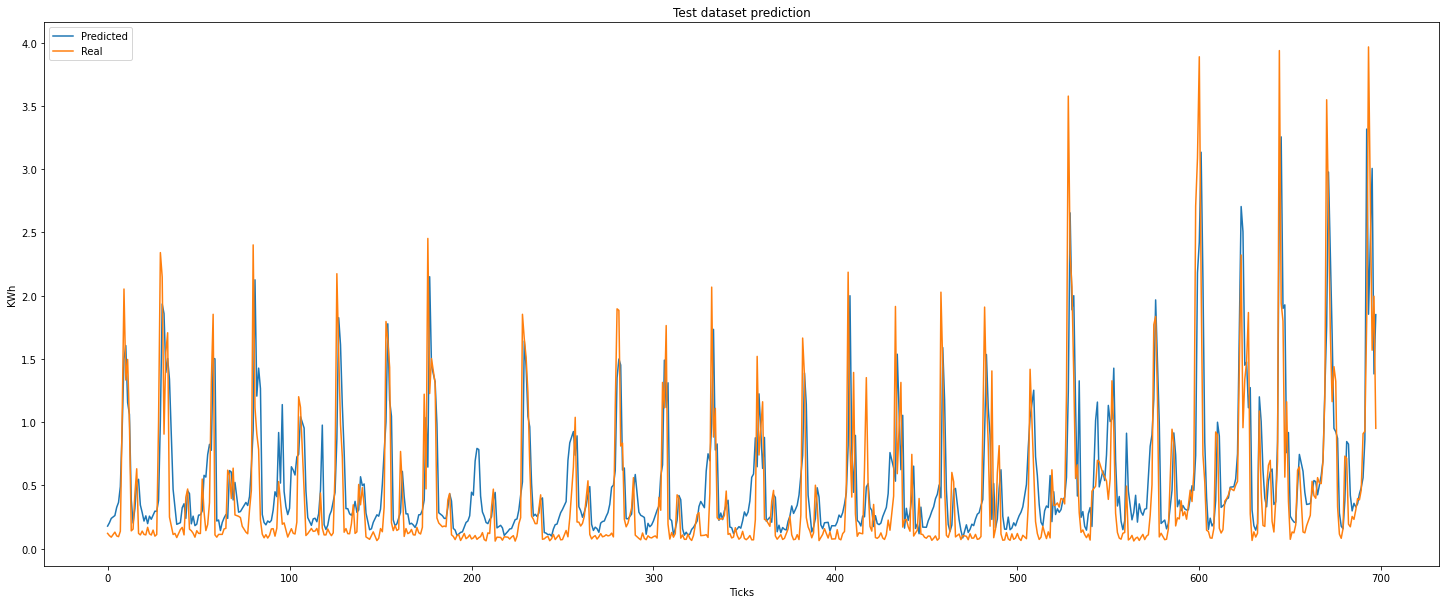

In [572]:
plt.figure(figsize = (25,10))
predictions_svr = svr_fit.predict(X_test_filt[1])
for i in range(len(predictions_svr)):
    if predictions_svr[i] < 0:
        predictions_svr[i] = 0
plt.plot(weather_energy.index[:len(predictions_svr)], predictions_svr, label = 'Predicted')
plt.plot(weather_energy.index[:len(predictions_svr)],y_test_filt[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [573]:
test_score_svr = mean_squared_error(y_test_filt[1], predictions_svr)
print('Test MSE: %.3f' % test_score_svr)

Test MSE: 0.185


In [574]:
r2_score(y_test_filt[1], predictions_svr)

0.4823891771671064

In [575]:
mda(np.asarray(y_test_filt[1]), predictions_svr)

0.5447647951441578

In [576]:
test_score_mae = mean_absolute_error(y_test_filt[1], predictions_svr)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.278


## GPR

In [577]:
# fitting GPR on training data
kernels_gpr = kernels.RBF(length_scale = 0.51) * kernels.DotProduct() + kernels.WhiteKernel(noise_level = 0.2) 
gpr = GaussianProcessRegressor(kernel=kernels_gpr, random_state=0).fit(X_train[1], y_train[1])
gprscore = gpr.score(X_train[1], y_train[1])
print(gprscore)

0.6847211962529169


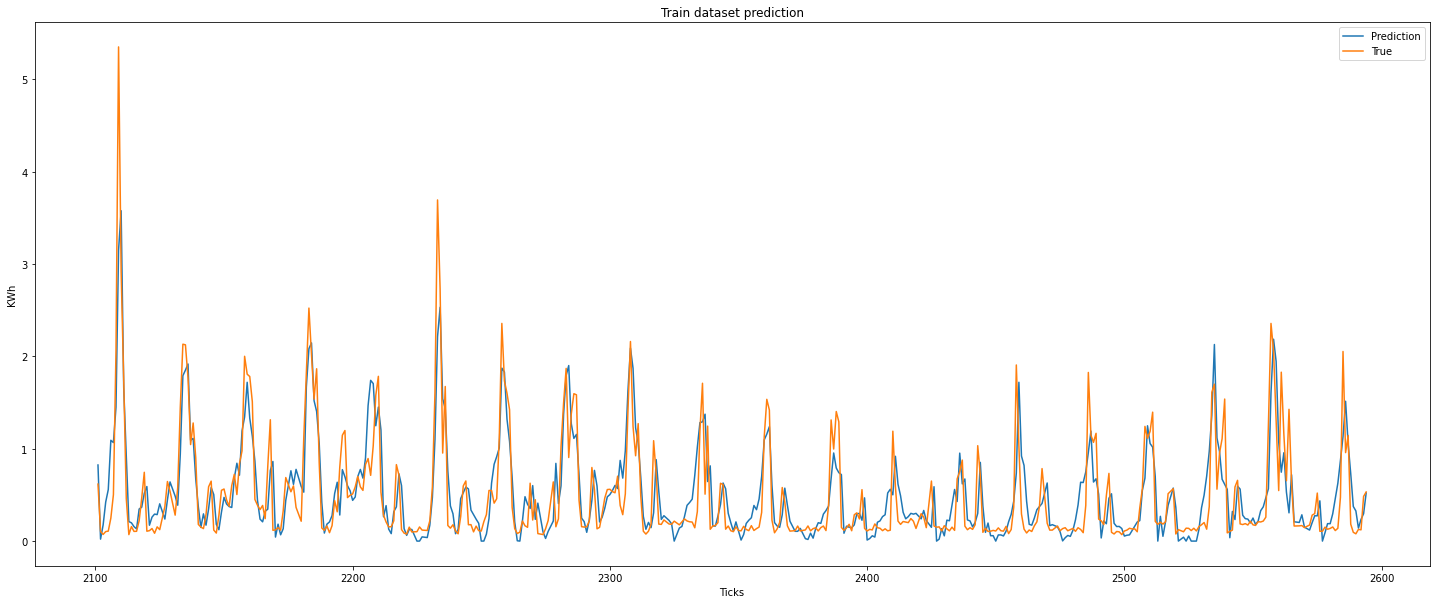

In [578]:
# plotting resulting predictions on train data
plt.figure(figsize = (25,10))
predictions_gpr_tr = gpr.predict(X_train[1], return_std = True)
for i in range(len(predictions_gpr_tr[0])):
    if predictions_gpr_tr[0][i] < 0:
        predictions_gpr_tr[0][i] = 0
plt.plot(weather_energy.index[2000:2474], predictions_gpr_tr[0][1500:1974], label = 'Prediction')
plt.plot(weather_energy.index[2000:2474],y_train[1][1500:1974], label = 'True')
#plt.fill_between(weather_energy.index[:2000], predictions_gpr_tr[0].flatten() + predictions_gpr_tr[1], predictions_gpr_tr[0].flatten() - predictions_gpr_tr[1], color='g', alpha=0.2)
plt.title('Train dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

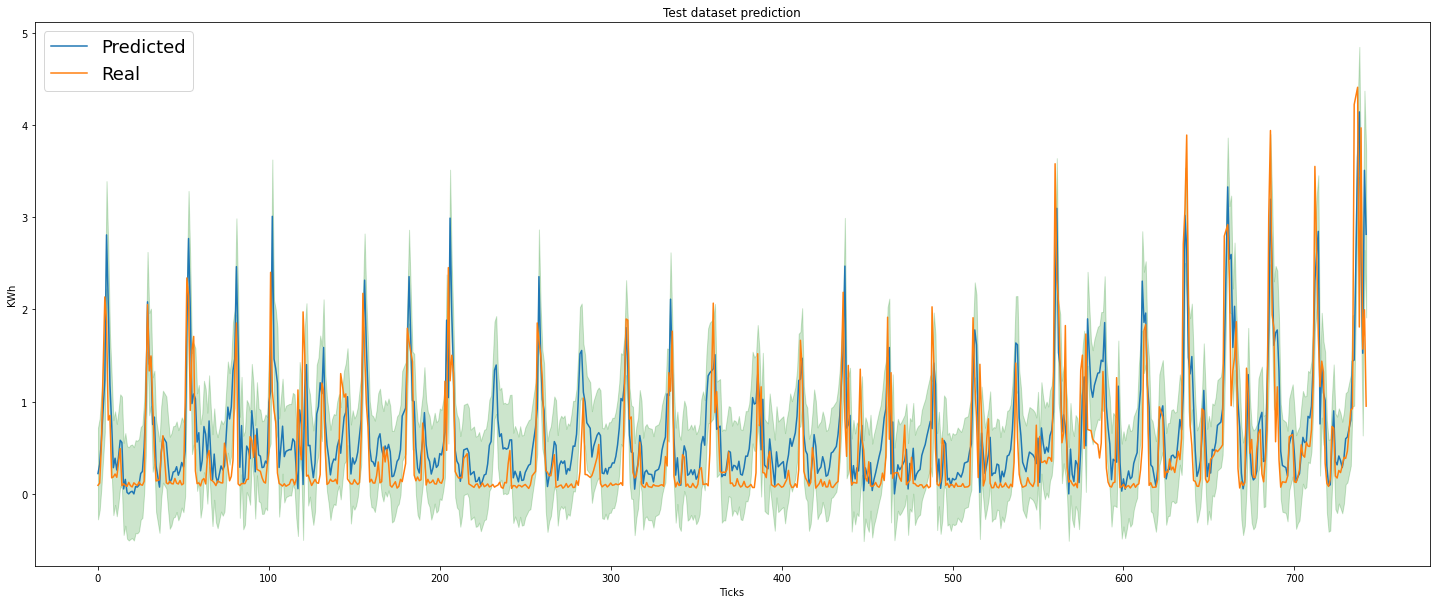

In [579]:
# fitting on test data and plotting the result
plt.figure(figsize = (25,10))
predictions_gpr = gpr.predict(X_test[1], return_std = True)
for i in range(len(predictions_gpr[0])):
    if predictions_gpr[0][i] < 0:
        predictions_gpr[0][i] = 0
plt.plot(weather_energy.index[:len(y_test[1])], predictions_gpr[0], label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test[1])],y_test[1], label = 'Real')
plt.fill_between(weather_energy.index[:len(y_test[1])], predictions_gpr[0].flatten() + predictions_gpr[1], predictions_gpr[0].flatten() - predictions_gpr[1], color='g', alpha=0.2)
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend(fontsize = 18)

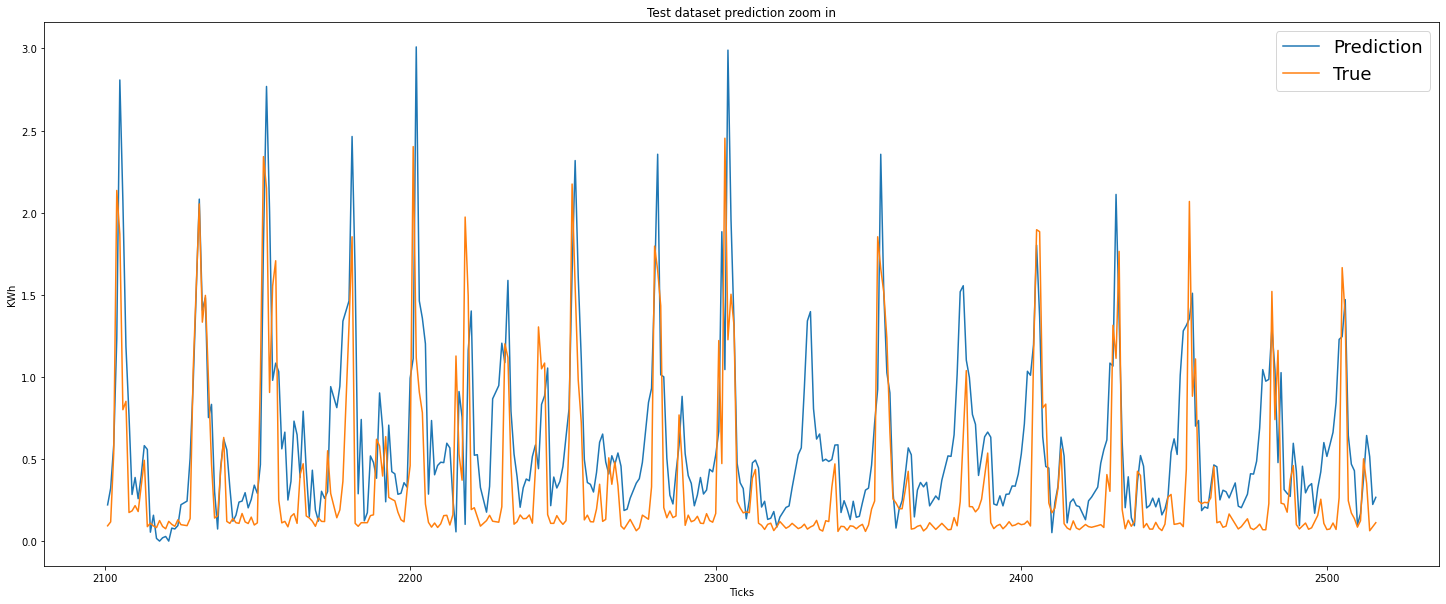

In [580]:
# zooming in
plt.figure(figsize = (25,10))
plt.plot(weather_energy.index[2000:2400], predictions_gpr[0][0:400], label = 'Prediction')
plt.plot(weather_energy.index[2000:2400],y_test[1][:400], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend(fontsize = 18)

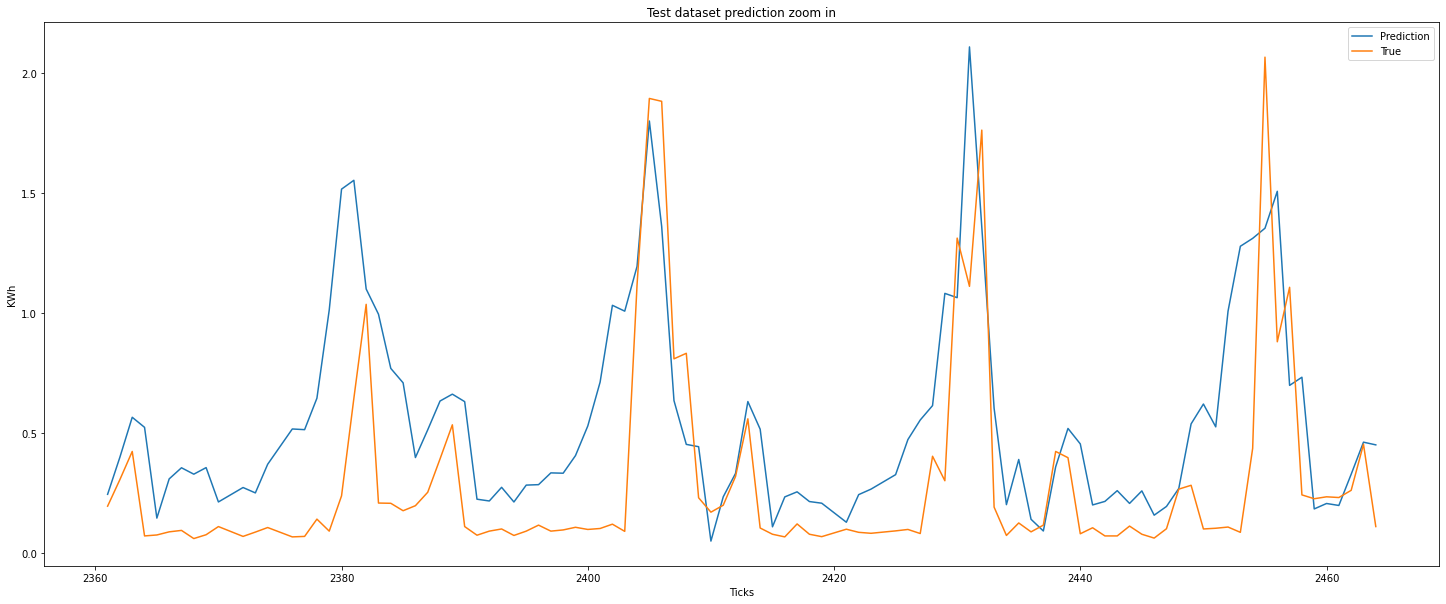

In [581]:
# zooming in
plt.figure(figsize = (25,10))
plt.plot(weather_energy.index[2250:2350], predictions_gpr[0][250:350], label = 'Prediction')
plt.plot(weather_energy.index[2250:2350],y_test[1][250:350], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [582]:
# metrics: MSE, R2, MAE, MDA
test_score = mean_squared_error(y_test[1], predictions_gpr[0])
print('Test MSE: %.3f' % test_score)

Test MSE: 0.255


In [583]:
r2_score(y_test[1], predictions_gpr[0])

0.4099190559074738

In [584]:
mda(np.asarray(y_test[1]), predictions_gpr[0])

0.5948644793152639

In [585]:
test_score_mae = mean_absolute_error(y_test[1], predictions_gpr[0])
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.355


### No outliers in train data

In [586]:
# same procedure as above
kernels_gpr = kernels.RBF(length_scale = 0.51) * kernels.DotProduct() + kernels.WhiteKernel(noise_level = 0.2) 
gpr = GaussianProcessRegressor(kernel=kernels_gpr, random_state=0).fit(X_train_no_out[1], y_train_no_out[1])
gprscore = gpr.score(X_train_no_out[1], y_train_no_out[1])
print(gprscore)

0.7528478318538772


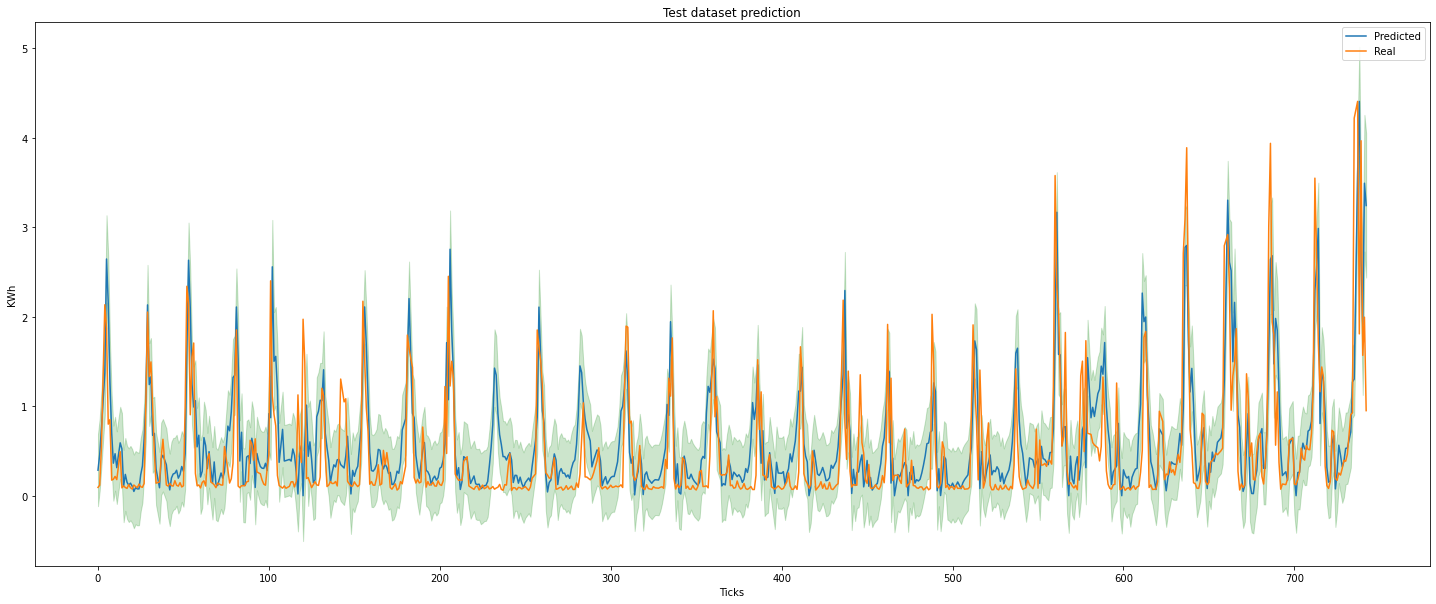

In [587]:
plt.figure(figsize = (25,10))
predictions_gpr = gpr.predict(X_test[1], return_std = True)
for i in range(len(predictions_gpr[0])):
    if predictions_gpr[0][i] < 0:
        predictions_gpr[0][i] = 0
plt.plot(weather_energy.index[:len(y_test[1])], predictions_gpr[0], label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test[1])],y_test[1], label = 'Real')
plt.fill_between(weather_energy.index[:len(y_test[1])], predictions_gpr[0].flatten() + predictions_gpr[1], predictions_gpr[0].flatten() - predictions_gpr[1], color='g', alpha=0.2)
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [588]:
test_score = mean_squared_error(y_test[1], predictions_gpr[0])
print('Test MSE: %.3f' % test_score)

Test MSE: 0.235


In [589]:
r2_score(y_test[1], predictions_gpr[0])

0.4544910873242155

In [590]:
mda(np.asarray(y_test[1]), predictions_gpr[0])

0.4973392402538863

In [591]:
test_score_mae = mean_absolute_error(y_test[1], predictions_gpr[0])
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.317


### No outliers in all data

In [683]:
kernels_gpr = kernels.RBF(length_scale = 100.51) * kernels.DotProduct() + kernels.WhiteKernel(noise_level = 0.2)
gpr = GaussianProcessRegressor(kernel=kernels_gpr, random_state=0).fit(X_train_filt[1], y_train_filt[1])
gprscore = gpr.score(X_train_filt[1], y_train_filt[1])
print(gprscore)

0.7527976046636992


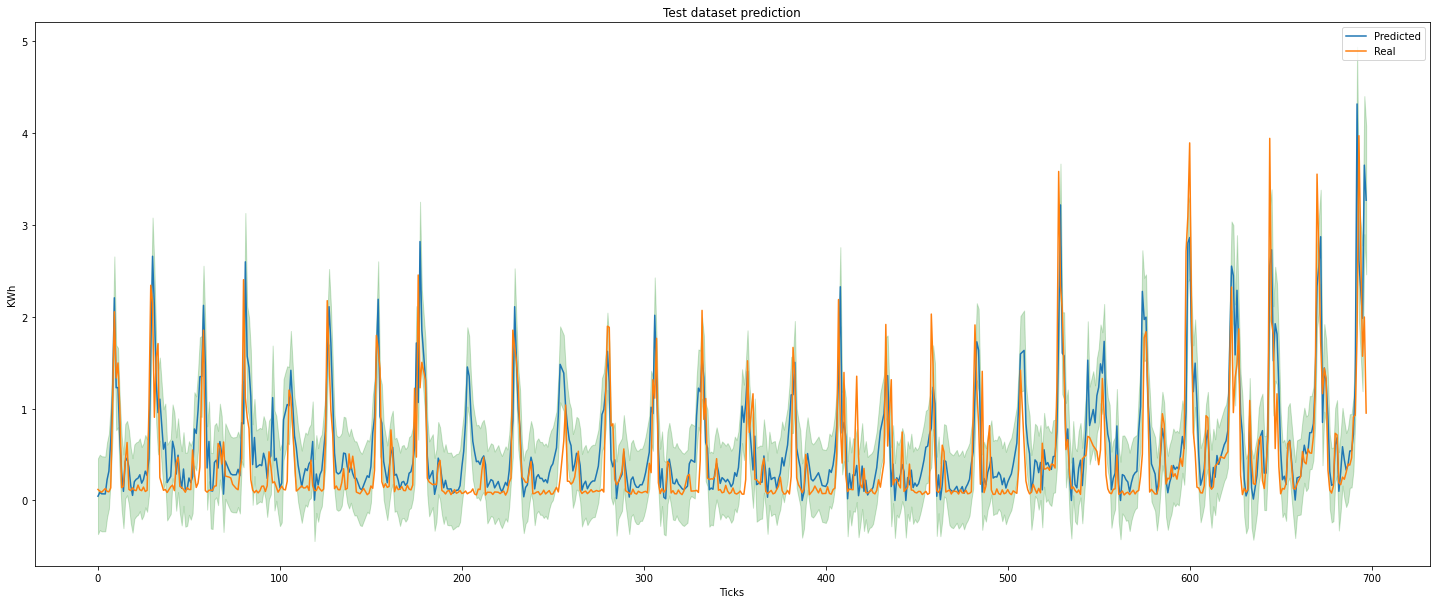

In [684]:
plt.figure(figsize = (25,10))
predictions_gpr = gpr.predict(X_test_filt[1], return_std = True)
for i in range(len(predictions_gpr[0])):
    if predictions_gpr[0][i] < 0:
        predictions_gpr[0][i] = 0
plt.plot(weather_energy.index[:len(y_test_filt[1])], predictions_gpr[0], label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test_filt[1])],y_test_filt[1], label = 'Real')
plt.fill_between(weather_energy.index[:len(y_test_filt[1])], predictions_gpr[0].flatten() + predictions_gpr[1], predictions_gpr[0].flatten() - predictions_gpr[1], color='g', alpha=0.2)
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [685]:
test_score = mean_squared_error(y_test_filt[1], predictions_gpr[0])
print('Test MSE: %.3f' % test_score)

Test MSE: 0.202


In [686]:
r2_score(y_test_filt[1], predictions_gpr[0])

0.4339050264156974

In [687]:
mda(np.asarray(y_test_filt[1]), predictions_gpr[0])

0.5978755690440061

In [688]:
test_score_mae = mean_absolute_error(y_test_filt[1], predictions_gpr[0])
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.295


## XGBoost

In [648]:
# declaring model with XGBoost hyperparameters
model = XGBRegressor(objective='reg:squarederror', n_estimators=500, min_child_weight=0.8, max_depth= 8, learning_rate= 0.05, gamma= 0.9)

In [649]:
# fitting model declared above on train data
model.fit(X_train[1], y_train[1])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.9, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_delta_step=0,
             max_depth=8, min_child_weight=0.8, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [650]:
# predicting on test data
pred_xg = model.predict(X_test[1])

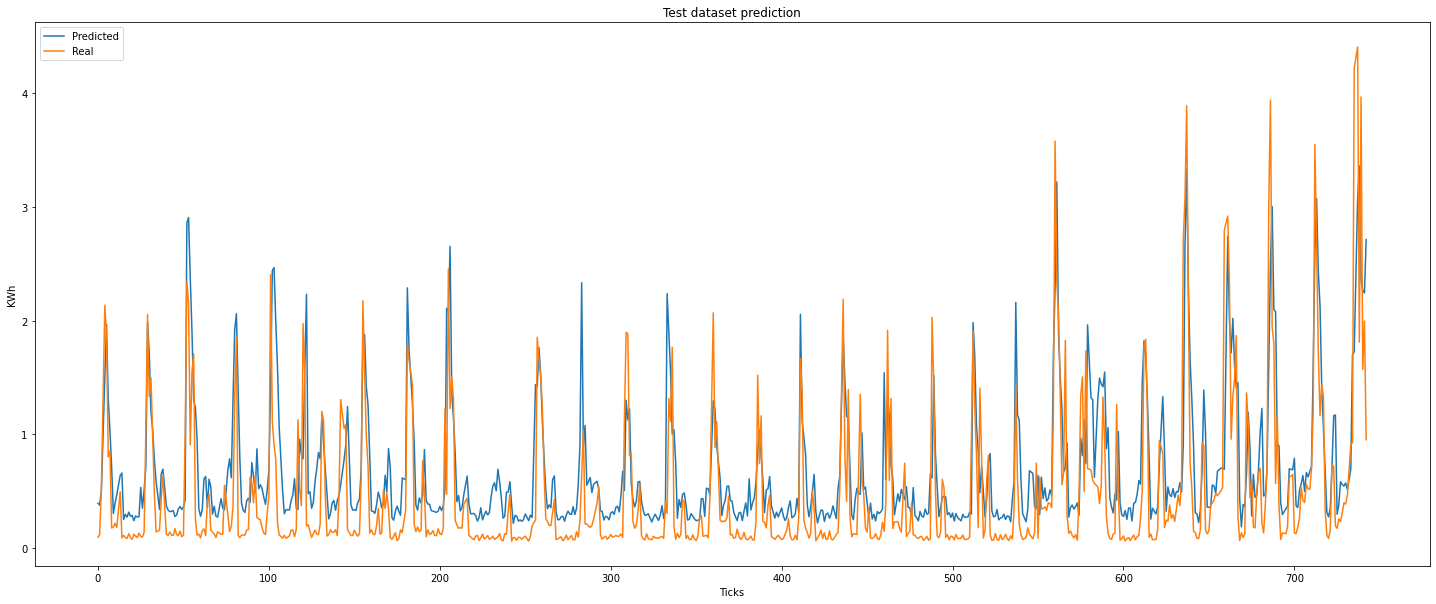

In [651]:
# plotting the result
plt.figure(figsize = (25,10))
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(weather_energy.index[:len(y_test[1])], pred_xg, label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test[1])],y_test[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

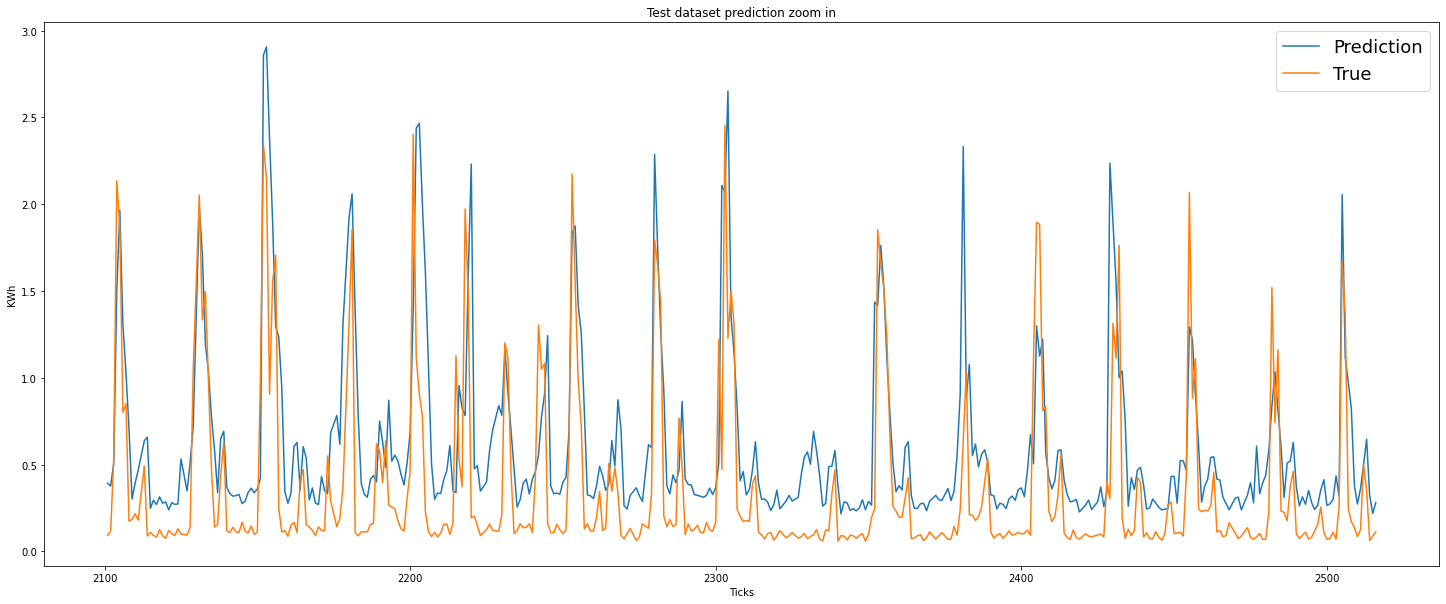

In [652]:
# zooming in
plt.plot(weather_energy.index[2000:2400], pred_xg[:400], label = 'Prediction')
plt.plot(weather_energy.index[2000:2400],y_test[1][:400], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend(fontsize = 18)

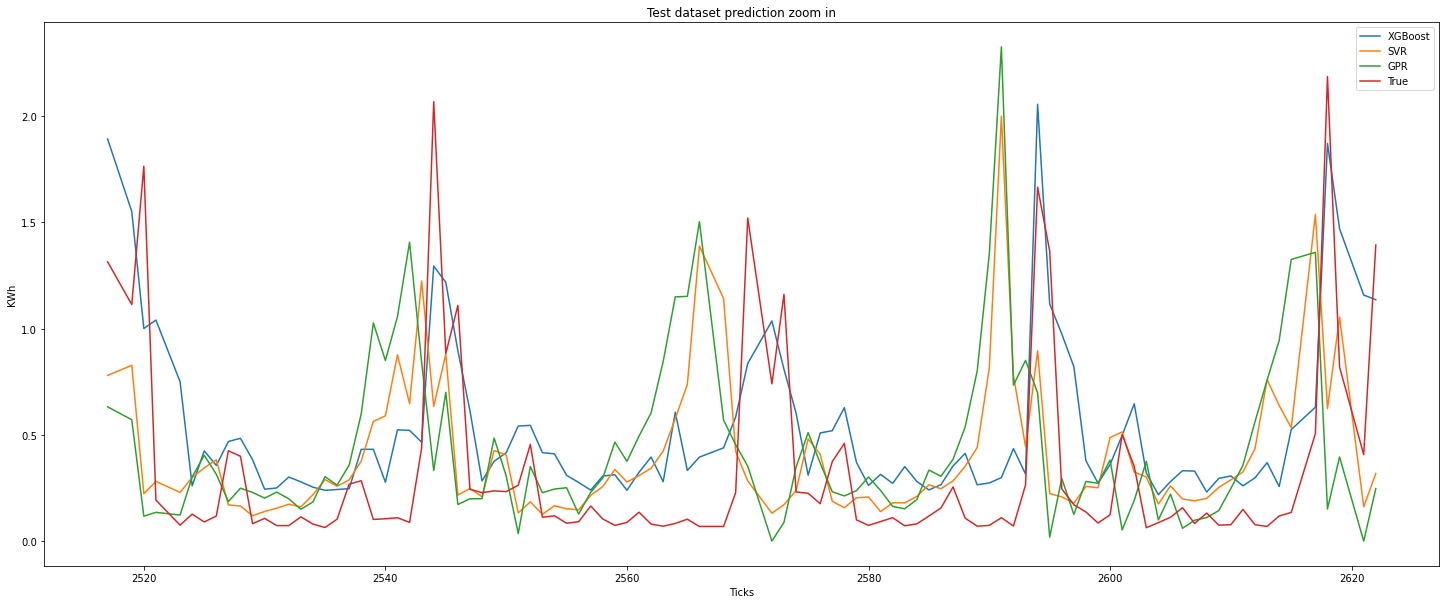

In [653]:
# zooming in and comparing with other algorithms
plt.plot(weather_energy.index[2400:2500], pred_xg[315:415], label = 'XGBoost')
plt.plot(weather_energy.index[2400:2500], predictions_svr[315:415], label = 'SVR')
plt.plot(weather_energy.index[2400:2500], predictions_gpr[0][315:415], label = 'GPR')
plt.plot(weather_energy.index[2400:2500],y_test[1][315:415], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [654]:
# metrics: MSE, R2, MAE, MDA
test_score = mean_squared_error(y_test[1], pred_xg)
print('Test MSE: %.3f' % test_score)

Test MSE: 0.225


In [655]:
r2_score(y_test[1], pred_xg)

0.47873161817423826

In [656]:
mda(np.asarray(y_test[1]), pred_xg)

0.49710725049399573

In [657]:
test_score_mae = mean_absolute_error(y_test[1], pred_xg)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.346


### No outliers in train data

In [698]:
# same procedure as above
model = XGBRegressor(objective='reg:squarederror', n_estimators=500, min_child_weight=0.4, max_depth= 14, learning_rate= 0.02, gamma= 0.8)

In [699]:
model.fit(X_train_no_out[1], y_train_no_out[1])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.8, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.02, max_delta_step=0,
             max_depth=14, min_child_weight=0.4, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [700]:
pred_xg = model.predict(X_test[1])

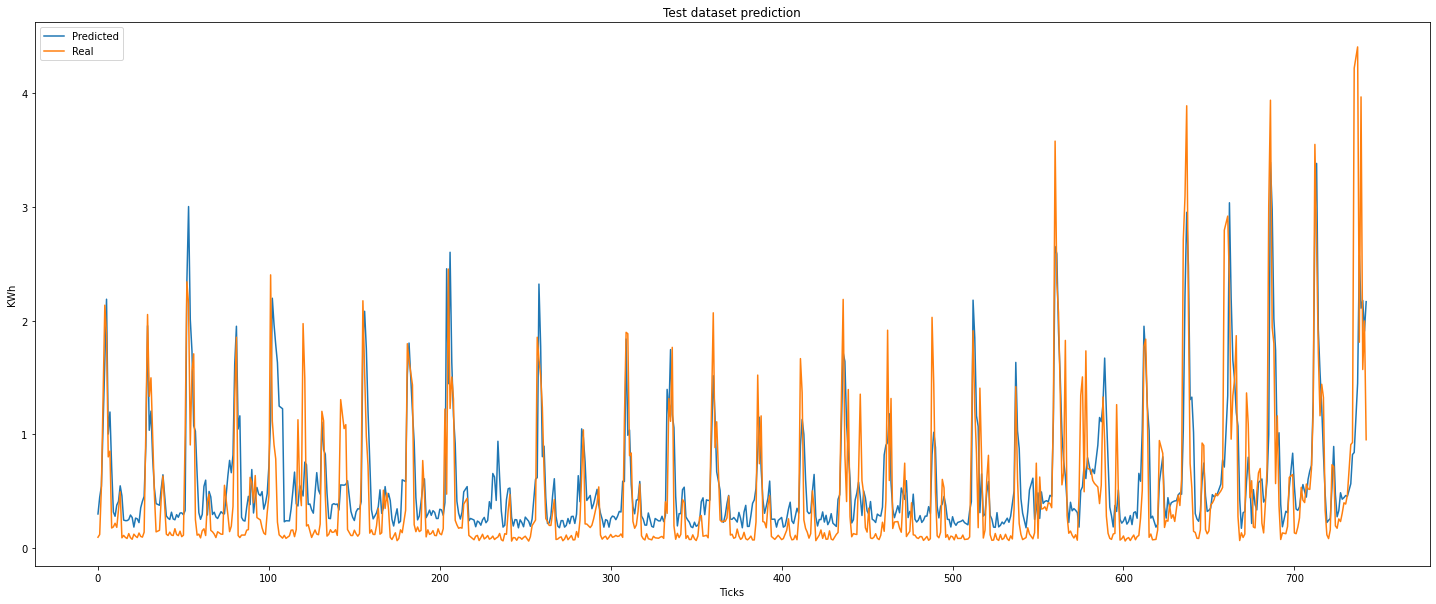

In [701]:
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(weather_energy.index[:len(y_test[1])], pred_xg, label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test[1])],y_test[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

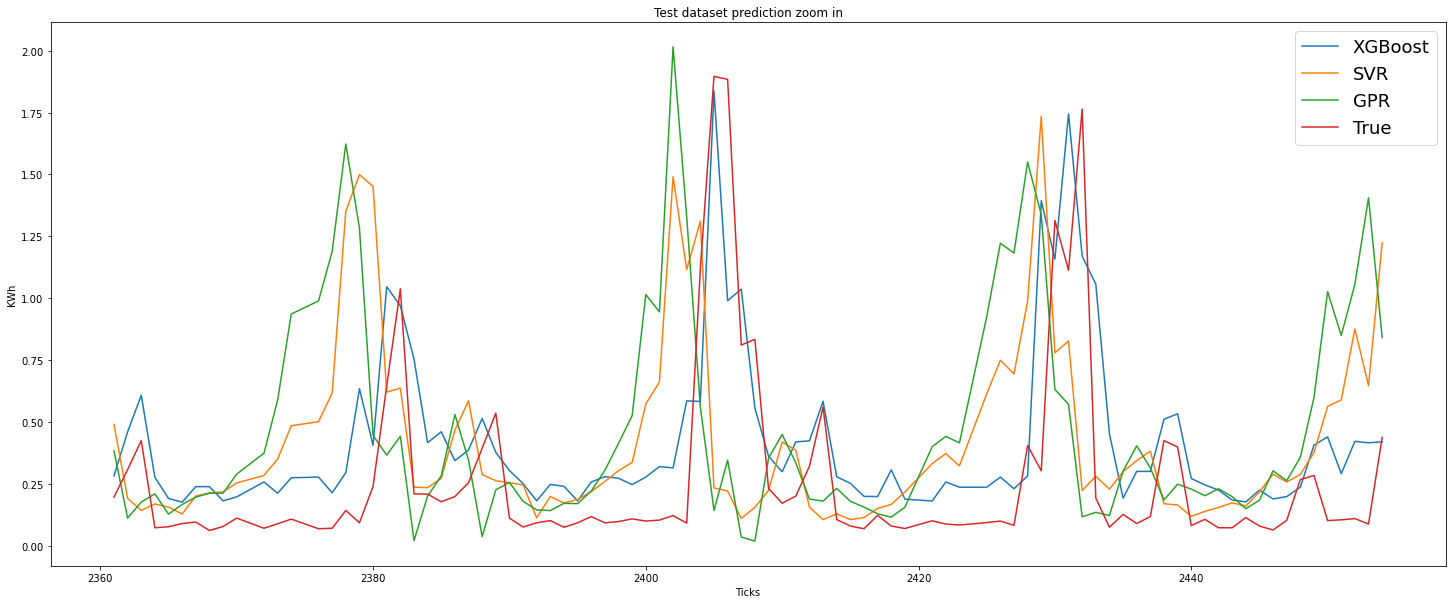

In [702]:
plt.plot(weather_energy.index[2250:2340], pred_xg[250:340], label = 'XGBoost')
plt.plot(weather_energy.index[2250:2340], predictions_svr[250:340], label = 'SVR')
plt.plot(weather_energy.index[2250:2340], predictions_gpr[0][250:340], label = 'GPR')
plt.plot(weather_energy.index[2250:2340],y_test[1][250:340], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend(fontsize = 18)

In [703]:
test_score = mean_squared_error(y_test[1], pred_xg)
print('Test MSE: %.3f' % test_score)

Test MSE: 0.195


In [704]:
r2_score(y_test[1], pred_xg)

0.5477251448976959

In [705]:
mda(np.asarray(y_test[1]), pred_xg)

0.4936294390935305

In [706]:
test_score_mae = mean_absolute_error(y_test[1], pred_xg)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.292


### No outliers in all data

In [667]:
# same procedure as above
model = XGBRegressor(objective='reg:squarederror', n_estimators=500, min_child_weight=0.4, max_depth= 14, learning_rate= 0.02, gamma= 0.8)

In [668]:
model.fit(X_train_filt[1], y_train_filt[1])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0.8, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.02, max_delta_step=0,
             max_depth=14, min_child_weight=0.4, missing=nan,
             monotone_constraints='()', n_estimators=400, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [669]:
pred_xg = model.predict(X_test_filt[1])

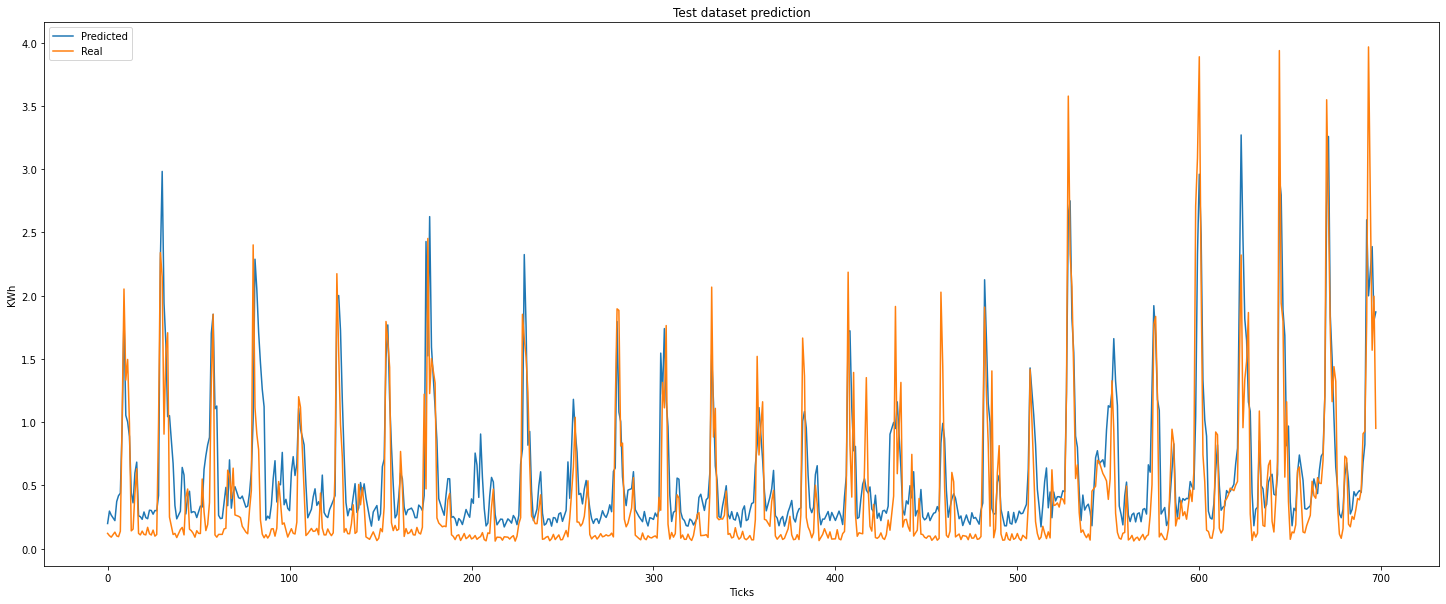

In [670]:
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(weather_energy.index[:len(y_test_filt[1])], pred_xg, label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test_filt[1])],y_test_filt[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

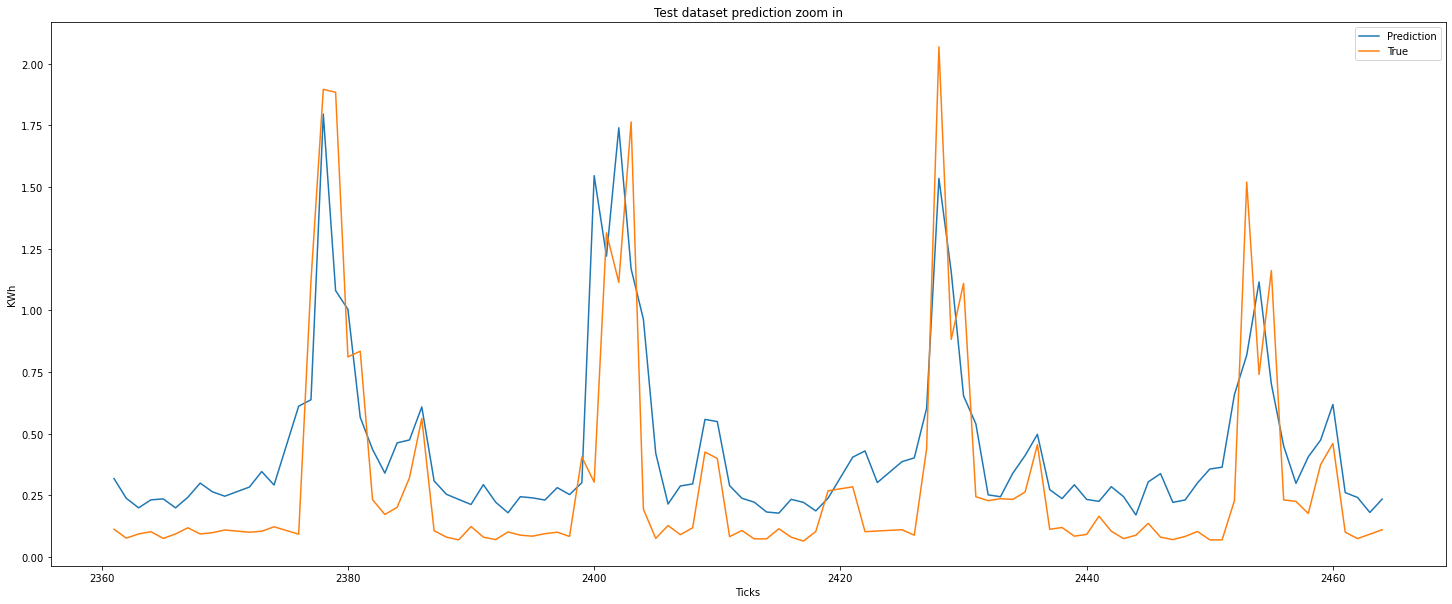

In [671]:
plt.plot(weather_energy.index[2250:2350], pred_xg[250:350], label = 'Prediction')
plt.plot(weather_energy.index[2250:2350],y_test_filt[1][250:350], label = 'True')
plt.title('Test dataset prediction zoom in')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [672]:
test_score = mean_squared_error(y_test_filt[1], pred_xg)
print('Test MSE: %.3f' % test_score)

Test MSE: 0.146


In [673]:
r2_score(y_test_filt[1], pred_xg)

0.5906091133242859

In [674]:
mda(np.asarray(y_test_filt[1]), pred_xg)

0.5493171471927162

In [675]:
test_score_mae = mean_absolute_error(y_test_filt[1], pred_xg)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.273


## LSTM

In [94]:
#
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim

        # LSTM layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional = True
        )

        # Fully connected layer
        self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_().cuda()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        out = out[:, -1, :]

        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.fc(out)

        return out

In [95]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [458]:
X_train_tensors = Variable(torch.Tensor(X_train[1].values))
X_test_tensors = Variable(torch.Tensor(X_test[1].values))

y_train_tensors = Variable(torch.Tensor(y_train[1].values)).cuda()
y_test_tensors = Variable(torch.Tensor(y_test[1].values)).cuda()

### No outliers in train data

In [423]:
X_train_tensors = Variable(torch.Tensor(X_train_no_out[1].values))
X_test_tensors = Variable(torch.Tensor(X_test[1].values))

y_train_tensors = Variable(torch.Tensor(y_train_no_out[1].values)).cuda()
y_train_tensors = torch.reshape(y_train_tensors,   (y_train_tensors.shape[0], 1))
y_test_tensors = Variable(torch.Tensor(y_test[1].values)).cuda()
y_test_tensors = torch.reshape(y_test_tensors,   (y_test_tensors.shape[0], 1))

### No outliers in all data

In [446]:
X_train_tensors = Variable(torch.Tensor(X_train_filt[1].values))
X_test_tensors = Variable(torch.Tensor(X_test_filt[1].values))

y_train_tensors = Variable(torch.Tensor(y_train_filt[1].values)).cuda()
y_train_tensors = torch.reshape(y_train_tensors,   (y_train_tensors.shape[0], 1))
y_test_tensors = Variable(torch.Tensor(y_test_filt[1].values)).cuda()
y_test_tensors = torch.reshape(y_test_tensors,   (y_test_tensors.shape[0], 1))

----------------------------------------

In [459]:
X_train_tensors_final = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1])).cuda()

X_test_tensors_final = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])).cuda()

In [460]:
num_epochs = 1000 #1000 epochs
learning_rate = 0.02 #0.2 lr 

input_size = 23 #number of features
num_layers = 4 #number of stacked lstm layers
hidden_layers = 50 #number of hidden layers
num_classes = 1 #number of output classes 
dropout_proba = 0.2

In [461]:
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(torch.mean(torch.pow((torch.log(actual + 1) - torch.log(pred + 1)),2)))

In [462]:
model = LSTMModel(input_size, hidden_layers, num_layers, num_classes, dropout_proba).to(device)
criterion = torch.nn.L1Loss()    # mean-squared error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.8)

In [463]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_final) #forward pass
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0
    # obtain the loss function
    loss = criterion(outputs, y_train_tensors)

    loss.backward() #calculates the loss of the loss function

    optimizer.step() #improve from loss, i.e backprop
    scheduler.step()
   # if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item())) 
    

Epoch: 0, loss: 0.75831
Epoch: 1, loss: 0.55977
Epoch: 2, loss: 0.54413
Epoch: 3, loss: 0.47617
Epoch: 4, loss: 0.39861
Epoch: 5, loss: 0.37400
Epoch: 6, loss: 0.36727
Epoch: 7, loss: 0.36178
Epoch: 8, loss: 0.36767
Epoch: 9, loss: 0.36101
Epoch: 10, loss: 0.35666
Epoch: 11, loss: 0.35703
Epoch: 12, loss: 0.34530
Epoch: 13, loss: 0.34849
Epoch: 14, loss: 0.34953
Epoch: 15, loss: 0.34376
Epoch: 16, loss: 0.33832
Epoch: 17, loss: 0.33153
Epoch: 18, loss: 0.33428
Epoch: 19, loss: 0.32304
Epoch: 20, loss: 0.32535
Epoch: 21, loss: 0.32136
Epoch: 22, loss: 0.31566
Epoch: 23, loss: 0.31309
Epoch: 24, loss: 0.30579
Epoch: 25, loss: 0.30432
Epoch: 26, loss: 0.30384
Epoch: 27, loss: 0.29709
Epoch: 28, loss: 0.29909
Epoch: 29, loss: 0.29382
Epoch: 30, loss: 0.28973
Epoch: 31, loss: 0.28624
Epoch: 32, loss: 0.28088
Epoch: 33, loss: 0.28327
Epoch: 34, loss: 0.27911
Epoch: 35, loss: 0.27802
Epoch: 36, loss: 0.27744
Epoch: 37, loss: 0.27134
Epoch: 38, loss: 0.27047
Epoch: 39, loss: 0.27007
Epoch: 40,

Epoch: 328, loss: 0.09534
Epoch: 329, loss: 0.09453
Epoch: 330, loss: 0.09134
Epoch: 331, loss: 0.09629
Epoch: 332, loss: 0.09173
Epoch: 333, loss: 0.09420
Epoch: 334, loss: 0.09215
Epoch: 335, loss: 0.09324
Epoch: 336, loss: 0.09118
Epoch: 337, loss: 0.09475
Epoch: 338, loss: 0.09766
Epoch: 339, loss: 0.09397
Epoch: 340, loss: 0.09239
Epoch: 341, loss: 0.09009
Epoch: 342, loss: 0.09269
Epoch: 343, loss: 0.09137
Epoch: 344, loss: 0.09104
Epoch: 345, loss: 0.09246
Epoch: 346, loss: 0.09209
Epoch: 347, loss: 0.09260
Epoch: 348, loss: 0.09125
Epoch: 349, loss: 0.09206
Epoch: 350, loss: 0.09247
Epoch: 351, loss: 0.09134
Epoch: 352, loss: 0.09172
Epoch: 353, loss: 0.09050
Epoch: 354, loss: 0.08978
Epoch: 355, loss: 0.08703
Epoch: 356, loss: 0.09137
Epoch: 357, loss: 0.08473
Epoch: 358, loss: 0.09227
Epoch: 359, loss: 0.08948
Epoch: 360, loss: 0.09041
Epoch: 361, loss: 0.09009
Epoch: 362, loss: 0.08823
Epoch: 363, loss: 0.09065
Epoch: 364, loss: 0.09219
Epoch: 365, loss: 0.09128
Epoch: 366, 

Epoch: 657, loss: 0.06933
Epoch: 658, loss: 0.07000
Epoch: 659, loss: 0.06982
Epoch: 660, loss: 0.06821
Epoch: 661, loss: 0.06883
Epoch: 662, loss: 0.06837
Epoch: 663, loss: 0.06675
Epoch: 664, loss: 0.06995
Epoch: 665, loss: 0.06714
Epoch: 666, loss: 0.06839
Epoch: 667, loss: 0.06831
Epoch: 668, loss: 0.06890
Epoch: 669, loss: 0.06682
Epoch: 670, loss: 0.06683
Epoch: 671, loss: 0.07199
Epoch: 672, loss: 0.06864
Epoch: 673, loss: 0.06681
Epoch: 674, loss: 0.06657
Epoch: 675, loss: 0.06998
Epoch: 676, loss: 0.06954
Epoch: 677, loss: 0.06449
Epoch: 678, loss: 0.07095
Epoch: 679, loss: 0.06710
Epoch: 680, loss: 0.06855
Epoch: 681, loss: 0.06819
Epoch: 682, loss: 0.06844
Epoch: 683, loss: 0.06852
Epoch: 684, loss: 0.06988
Epoch: 685, loss: 0.06999
Epoch: 686, loss: 0.06609
Epoch: 687, loss: 0.06760
Epoch: 688, loss: 0.06528
Epoch: 689, loss: 0.06809
Epoch: 690, loss: 0.06732
Epoch: 691, loss: 0.06763
Epoch: 692, loss: 0.06626
Epoch: 693, loss: 0.06838
Epoch: 694, loss: 0.06688
Epoch: 695, 

Epoch: 982, loss: 0.05827
Epoch: 983, loss: 0.05874
Epoch: 984, loss: 0.05731
Epoch: 985, loss: 0.05874
Epoch: 986, loss: 0.06015
Epoch: 987, loss: 0.06010
Epoch: 988, loss: 0.05978
Epoch: 989, loss: 0.05836
Epoch: 990, loss: 0.06165
Epoch: 991, loss: 0.06010
Epoch: 992, loss: 0.05727
Epoch: 993, loss: 0.05867
Epoch: 994, loss: 0.05876
Epoch: 995, loss: 0.06028
Epoch: 996, loss: 0.05736
Epoch: 997, loss: 0.06124
Epoch: 998, loss: 0.06058
Epoch: 999, loss: 0.06010


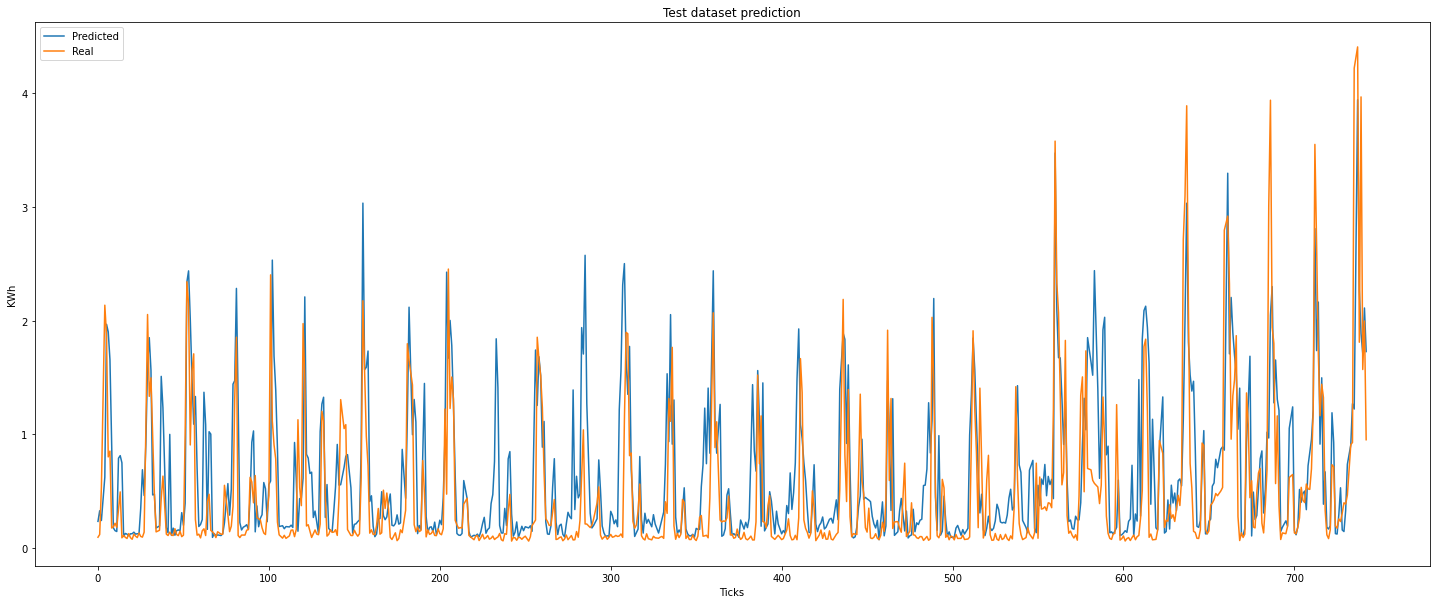

In [464]:
test_predict = model(X_test_tensors_final)#forward pass
data_predict = test_predict.cpu().data.numpy() #numpy conversion
#data_predict = mm.inverse_transform(data_predict) #reverse transformation

plt.figure(figsize = (25,10))

plt.plot(weather_energy.index[:len(y_test[1])], data_predict, label = 'Predicted')
plt.plot(weather_energy.index[:len(y_test[1])],y_test[1], label = 'Real')
#Uncomment next lines for plot for output for data with no outliers at all
# plt.plot(weather_energy.index[:len(y_test_filt[1])], data_predict, label = 'Predicted')
# plt.plot(weather_energy.index[:len(y_test_filt[1])],y_test_filt[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [465]:
#metrics: MSE, R2, MDA, MAE
test_score = mean_squared_error(y_test[1], data_predict)
# test_score = mean_squared_error(y_test_filt[1], data_predict)
print('Test MSE: %.3f' % test_score)

Test MSE: 0.283


In [466]:
r2_score(y_test[1], data_predict)
# r2_score(y_test_filt[1], data_predict)

0.3443188691238679

In [467]:
mda(np.asarray(y_test[1]), data_predict)
# mda(np.asarray(y_test_filt[1]), data_predict)

0.5520684736091298

In [468]:
test_score_mae = mean_absolute_error(y_test[1], data_predict)
# test_score_mae = mean_absolute_error(y_test_filt[1], data_predict)
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.337


# Meta Learning

In [469]:
# function that imitates scipy optimizer for GPR algorithm (needed for MAML meta learning algorithm)
def constrained_optimization(self, obj_func, inner_step_size, outer_step_size, iterations, kernel, X_train, y_train, tasks, initial_theta, bounds):
    theta = initial_theta
    for iteration in range(iterations):
        lml, grad = obj_func(initial_theta, inner_step_size, kernel, X_train, y_train, eval_gradient=True) #inner loop
        for i in range(len(grad)):
            theta[i] = theta[i] - outer_step_size*grad[i] # gradient update of the outer loop
        outer_step_size = outer_step_size * (1 - iteration/iterations) # scheduling of learning rate
    theta_opt = theta
    return theta_opt

In [470]:
# objective function to optimize (inner loop objective function for MAML)
def obj_func(theta, inner_step_size, kernel, X_train, y_train, tasks = 35, eval_gradient=True):
    lml_tot = 0
    grad_tot = 0
    for task in range(tasks):
        kernel.theta = theta
        gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train[task], y_train[task])
        lml, grad = gpr.log_marginal_likelihood(
            theta, eval_gradient=True, clone_kernel=False) #getting marginal likelihood and its grad for every task
        for i in range(len(grad)):
            theta[i] = theta[i] + inner_step_size*grad[i]  #inner loop gradient update
        lml_tot += lml
        grad_tot += grad  
    return -lml_tot, -grad_tot

In [471]:
# function that imitates scipy optimizer for GPR algorithm (needed for Reptile meta learning algorithm)
def constrained_optimization_rept(self, obj_func, inner_step_size, outer_step_size, iterations, kernel, X_train, y_train, tasks, initial_theta, bounds):
    theta = initial_theta
    for iteration in range(iterations):
        theta_new = obj_func_rept(initial_theta,kernel, inner_step_size, X_train, y_train, tasks, eval_gradient=True)
        theta = theta + outer_step_size*(theta_new - theta) #Reptile gradient update for outer loop
        outer_step_size = outer_step_size * (1 - iteration/iterations) #Scheduling of the learning rate
    theta_opt = theta
    return theta_opt

In [472]:
# objective function to optimize (inner loop objective function for Reptile)
def obj_func_rept(theta,kernel, inner_step_size, X_train, y_train, tasks, eval_gradient=True):
    lml_tot = 0
    grad_tot = 0
    if eval_gradient:
        random_order = np.random.permutation(tasks)
        for task in range(tasks):
            indicies = random_order[task]
            kernel.theta = theta
            gpr = GaussianProcessRegressor(kernel=kernel, random_state=0).fit(X_train[indicies], y_train[indicies])
            lml, grad = gpr.log_marginal_likelihood(
                theta, eval_gradient=True, clone_kernel=False)
            for i in range(len(grad)):
                theta[i] = theta[i] + inner_step_size*grad[i] 
        return theta

In [473]:
# Meta Learning class implementation for Deep Learning
class Meta_Learning:
    def __init__(self, model):
        self.model = model.to(device)
    
    def train_maml(self, iterations, outer_step_size, inner_step_size, 
        inner_gradient_steps, X_train, y_train, X_query, y_query, tasks=10):
        loss = 0
        batches = 0
        for iteration in range(iterations):
            init_weights = deepcopy(self.model.state_dict())
            x_test = X_query.values
            y_test = y_query.values
            meta_params = {}
            for task in range(tasks): 
                # sample for meta-update
                x = X_train[task].values
                y = y_train[task].values
                #y = mm.transform(y) 
                for grad_step in range(inner_gradient_steps):
                    loss_base = self.train_loss(x,y)
                    loss_base.backward()
                    for param in self.model.parameters():
                        param.data -= inner_step_size * param.grad.data
                loss_meta = self.train_loss(x_test, y_test)
                loss_meta.backward()
                for name,param in self.model.named_parameters():
                    if(task == 0):
                        meta_params[name] =  param.grad.data
                    else:
                        meta_params[name] += param.grad.data
                loss += loss_meta.cpu().data.numpy()
                batches += 1
                self.model.load_state_dict(init_weights)
            learning_rate = outer_step_size * (1 - iteration/iterations)
            print(loss/batches, iteration)
            self.model.load_state_dict({name: init_weights[name] - 
                learning_rate/tasks * meta_params[name] for name in init_weights})

    def train_reptile(self, iterations, outer_step_size, inner_step_size, 
        inner_gradient_steps, X_train, y_train, X_query, y_query, tasks=10):
        loss = 0
        batches=0
        for iteration in range(iterations):
            init_weights = deepcopy(self.model.state_dict())
            for j in range(inner_gradient_steps):
                random_order = np.random.permutation(tasks)
                for start in range(0,tasks):
                    indicies = random_order[start]
                    y = y_train[indicies].values
                    #y = mm.transform(y)
                    loss_base = self.train_loss(X_train[indicies].values, y)
                    loss_base.backward()
                    for param in self.model.parameters():
                        param.data -= inner_step_size * param.grad.data
                    loss += loss_base.cpu().data.numpy()
                    batches += 1
            learning_rate = outer_step_size * (1 - iteration/iterations)
            curr_weights = self.model.state_dict()
            print(loss/batches, iteration)
            self.model.load_state_dict({name: (init_weights[name] + learning_rate * 
                (curr_weights[name] - init_weights[name])) for name in curr_weights})

    def train_loss(self, x, y):
        x = torch.tensor(x, dtype=torch.float32, device = device)
        y = torch.tensor(y, dtype=torch.float32, device = device)
        x = x[:, None, :]
        self.model.zero_grad()
        out = self.model(x)
        #MSE, MAE and LogLoss 
        #loss = (out - y).pow(2).mean()
        #loss = abs((out - y)).mean()
        loss = torch.sqrt(torch.mean(torch.pow((torch.log(y + 1) - torch.log(out + 1)),2)))
        return loss

    def evaluate(self, y_all, x_all, outer_step_size = 0.2, gradient_steps=10, inner_step_size=0.02):
        pred = [self.predict(x_all.values)]
        meta_weights = deepcopy(self.model.state_dict())
        params = {}
        for i in range(gradient_steps):
            loss_base = self.train_loss(x_all.values,y_all)
            loss_base.backward()
            for param in self.model.parameters():
                param.data -= inner_step_size * param.grad.data
            pred.append(self.predict(x_all.values))
        for name,param in self.model.named_parameters():
            params[name] =  param.grad.data
        self.model.load_state_dict({name: meta_weights[name] - 
                outer_step_size * params[name] for name in meta_weights})
        return {"pred": pred}

    def predict(self, x):
        x = torch.tensor(x, dtype=torch.float32, device=device)
        x = x[:, None, :]
        return self.model(x).cpu().data.numpy()
class Meta_Wave(nn.Module):
    def __init__(self, units):
        super(Meta_Wave, self).__init__()
        self.inp = nn.Linear(23, units)
        self.layer1 = nn.Linear(units,units)
        self.out = nn.Linear(units, 1)

    def forward(self,x):
        x = torch.tanh(self.inp(x))
        x = torch.tanh(self.layer1(x))
        output = self.out(x)
        return output

In [474]:
# Data preparation for Meta Learning
X_train_meta = []
y_train_meta = []
X_val_meta_dl = []
y_val_meta_dl = []
X_query_meta = []
y_query_meta = []
for i in range(len(ds)): 
    X_train_meta.append(X_train[i].sample(200, random_state = 0))
    y_train_meta.append(y_train[i].sample(200, random_state = 0))
    X_val_meta_dl.append(X_train[i].sample(50, random_state = 100))
    y_val_meta_dl.append(y_train[i].sample(50, random_state = 100))
    X_query_meta.append(X_train[i].sample(100, random_state = 10))
    y_query_meta.append(y_train[i].sample(100, random_state = 10))

In [475]:
# concatenating values for DL models
X_val_meta_dl = pd.concat(X_val_meta_dl)
y_val_meta_dl = pd.concat(y_val_meta_dl)

### GPR models

In [826]:
# parameters
init_ls = 0.5
init_nl = 0.2
tasks = 40
# reptile parameters
inner_step_size_rept = 0.01
outer_step_size_rept = 0.2
iterations_rept = 25
# MAML parameters
inner_step_size_maml = 0.01
outer_step_size_maml = 0.01
iterations_maml = 25

In [833]:
# Concatenating inputs into a single matrix for training on all samples
X_train_meta_gpr = pd.concat(X_train_meta)
y_train_meta_gpr = pd.concat(y_train_meta)
kernels_gpr = kernels.RBF(length_scale = init_ls) * kernels.DotProduct() + kernels.WhiteKernel(noise_level = inite_nl)
model = GaussianProcessRegressor(kernel=kernels_gpr, random_state=0).fit(X_train_meta_gpr, y_train_meta_gpr)
kernels_gpr = kernels_gpr.set_params(**(model.kernel_.get_params()))
model = GaussianProcessRegressor(kernel=kernels_gpr, random_state=0).fit(X_query_meta[1], y_query_meta[1])
gprscore = model.score(X_train[1], y_train[1])
print(gprscore)

0.30650916425451735


In [825]:
# Reptile GPR
kernels_gpr = kernels.RBF(length_scale = init_ls,  length_scale_bounds=(1e-06, 1000000.0)) * kernels.DotProduct() + kernels.WhiteKernel(noise_level = init_nl)
model = GaussianProcessRegressor(kernel=kernels_gpr, random_state=0)
theta_opt = constrained_optimization_rept(model,obj_func, inner_step_size_rept, outer_step_size_rept, iterations_rept, kernels_gpr, X_train_meta, 
                                     y_train_meta, tasks, initial_theta = model.kernel.theta, bounds = model.kernel.bounds)
# fixing kernel to resulting meta learning kernel
model.kernel.theta = theta_opt

# Adjusting model for a particular household
model = GaussianProcessRegressor(kernel=model.kernel, random_state=0).fit(X_query_meta[1], y_query_meta[1])
gprscore = model.score(X_train[1], y_train[1])
print(gprscore)

C:\Users\denis\Anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
C:\Users\denis\Anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:506: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


0.30650714929931067


In [839]:
#MAML GPR
kernels_gpr = kernels.RBF(length_scale = init_ls, length_scale_bounds=(1e-06, 1000000.0)) * kernels.DotProduct() + kernels.WhiteKernel(noise_level = init_nl) 
model = GaussianProcessRegressor(kernel=kernels_gpr, random_state=0)
theta_opt = constrained_optimization(model,obj_func, inner_step_size_maml, outer_step_size_maml, iterations_maml, kernels_gpr, X_train_meta, 
                                     y_train_meta, tasks, initial_theta = model.kernel.theta, bounds = model.kernel.bounds)
# fixing kernel to resulting meta learning kernel
model.kernel.theta = theta_opt

# Adjusting model for a particular household
model = GaussianProcessRegressor(kernel=model.kernel, random_state=0).fit(X_query_meta[1], y_query_meta[1])
gprscore = model.score(X_train[1], y_train[1])
print(gprscore)

0.4892748496678544


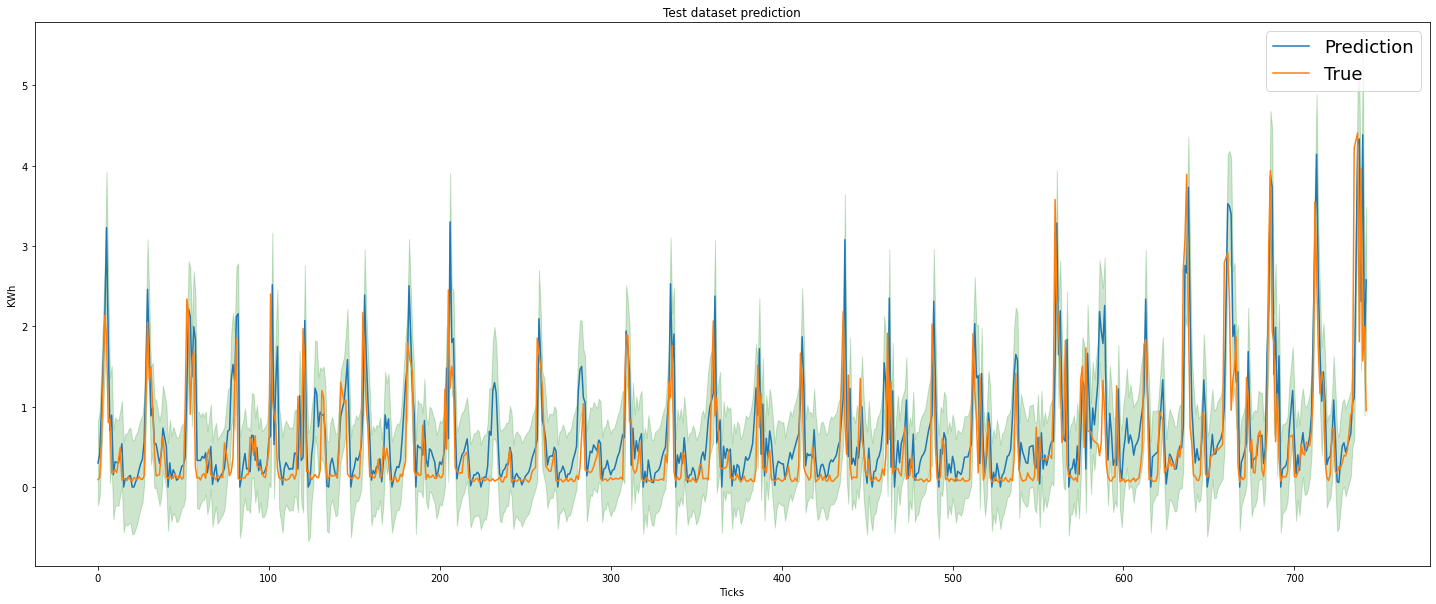

In [840]:
# Test predictions
predictions_gpr = model.predict(X_test[1], return_std = True)
for i in range(len(predictions_gpr[0])):
    if predictions_gpr[0][i] < 0:
        predictions_gpr[0][i] = 0
plt.figure(figsize = (25,10))
plt.plot(weather_energy.index[:len(predictions_gpr[0])], predictions_gpr[0], label = 'Prediction')
plt.plot(weather_energy.index[:len(predictions_gpr[0])],y_test[1], label = 'True')
plt.fill_between(weather_energy.index[:len(predictions_gpr[0])], predictions_gpr[0].flatten() + predictions_gpr[1], predictions_gpr[0].flatten() - predictions_gpr[1], color='g', alpha=0.2)
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend(fontsize = 18)

In [841]:
# metrics: MSE, MAE, R2, MDA
test_score = mean_squared_error(y_test[1], predictions_gpr[0])
print('Test MSE: %.3f' % test_score)

Test MSE: 0.328


In [842]:
r2_score(y_test[1], predictions_gpr[0])

0.23903399324773011

In [843]:
test_score_mae = mean_absolute_error(y_test[1], predictions_gpr[0])
print('Test MAE: %.3f' % test_score_mae)

Test MAE: 0.373


In [844]:
mda(np.asarray(y_test[1]), predictions_gpr[0])

0.5335235378031383

### Deep Learning models

In [478]:
# parameters 
n_epochs = 1000
external_step_size = 0.4
internal_step_size = 0.02
inner_grad_steps = 1
tasks = 40
#lstm parameters
input_size = 23   #number of features
num_layers = 1    #number of stacked lstm layers
hidden_size = 50  #hidden layer size
num_classes = 1   #number of output classes 
dropout_prob = 0.1

In [479]:
#model = Meta_Wave(128)
model = LSTMModel(input_size, hidden_size, num_layers, num_classes, dropout_prob).to(device)
meta = Meta_Learning(model)
# Training via Reptile algorithm
meta.train_reptile(n_epochs, external_step_size, internal_step_size,inner_grad_steps, 
                X_train_meta, y_train_meta, X_val_meta_dl, y_val_meta_dl, tasks)
# Uncomment next lines, to train through MAML algorithm
# meta.train_maml(n_epochs, external_step_size, internal_step_size,inner_grad_steps, 
#                 X_train_meta, y_train_meta, X_val_meta_dl, y_val_meta_dl, tasks)

0.45641331747174263 0
0.42946088230237367 1
0.4099213700120648 2
0.3957958798855543 3
0.3855277842283249 4
0.377691423582534 5
0.3713261505322797 6
0.36614186940714716 7
0.3617881571253141 8
0.35807030435651543 9
0.35483229414305906 10
0.3520128311899801 11
0.3495070623377195 12
0.3472508952287691 13
0.3452232577155034 14
0.34334517568349837 15
0.3416586609447704 16
0.34010200879226127 17
0.3386520840031536 18
0.33731831040233373 19
0.3360693931136103 20
0.3349085649052127 21
0.33383336453496115 22
0.33280600200717647 23
0.33185001311451195 24
0.3309346909634769 25
0.3300808921111403 26
0.32926486156481716 27
0.32849202880571626 28
0.3277553325394789 29
0.3270549174938952 30
0.32635934176505543 31
0.32571627571049966 32
0.32507108439527016 33
0.32446547482162713 34
0.3238954334571544 35
0.3233492607401835 36
0.3228206889605836 37
0.3223142919011223 38
0.32182651437353343 39
0.32135589458502645 40
0.32089695054150763 41
0.3204593905182772 42
0.32003152472051705 43
0.3196217746825682 44


0.29719540454143806 355
0.29718086559022844 356
0.2971667804864532 357
0.29715203202347734 358
0.2971379580048637 359
0.2971224023287192 360
0.29710821926912795 361
0.297092586180539 362
0.29707832038760756 363
0.29706031061657895 364
0.29704528871027985 365
0.29703070442737856 366
0.2970168864971999 367
0.29700317982240987 368
0.29698995899459396 369
0.2969760928127282 370
0.2969612861422682 371
0.2969480676626432 372
0.2969345052761429 373
0.2969207957426707 374
0.29690706336850975 375
0.29689380682224226 376
0.29688086193744784 377
0.2968672986007185 378
0.29685338899346164 379
0.2968394985823376 380
0.29682639493114504 381
0.2968121059068695 382
0.296797176906936 383
0.2967843127115206 384
0.29677073333286946 385
0.2967583214291383 386
0.2967460900900367 387
0.2967333007024501 388
0.29672102881643253 389
0.2967087487868793 390
0.29669642308726907 391
0.2966842471614821 392
0.2966715328754659 393
0.2966593275841656 394
0.2966468545561186 395
0.29663329064677135 396
0.296620257864776

0.29404870217966794 705
0.2940432384354622 706
0.2940373052916579 707
0.2940318588516839 708
0.29402631166194315 709
0.29402049706303074 710
0.2940150049436586 711
0.2940095223940982 712
0.29400393406231823 713
0.293998557398734 714
0.29399250652901204 715
0.29398694655739777 716
0.293981315968636 717
0.293975698179792 718
0.2939702929170906 719
0.29396493525532347 720
0.29395867114308755 721
0.2939531045941376 722
0.2939475900388081 723
0.29394223879097864 724
0.293936969738546 725
0.29393137341936565 726
0.2939258160038882 727
0.29392065633783326 728
0.2939154754334117 729
0.2939101730138267 730
0.2939044222138985 731
0.29389926631735463 732
0.29389410082692385 733
0.2938889250440561 734
0.2938836907327641 735
0.29387856599934187 736
0.2938733140544254 737
0.293868070822436 738
0.2938627608054997 739
0.2938574603191915 740
0.29385223171656144 741
0.2938469859103335 742
0.29384196006232294 743
0.2938367381966954 744
0.29383168629927425 745
0.2938263535487105 746
0.2938191332216848 747

In [480]:
# adjusting model for query input
meta.evaluate(y_query_meta[1].values, X_query_meta[1], outer_step_size = 0.5)

{'pred': [array([[0.6269896 ],
         [0.34363976],
         [1.0020396 ],
         [0.29292   ],
         [0.5263209 ],
         [0.34933797],
         [0.3914683 ],
         [0.30496112],
         [1.6465632 ],
         [0.37366512],
         [0.3770653 ],
         [0.49465907],
         [0.7716508 ],
         [0.73553884],
         [0.8811466 ],
         [0.3112806 ],
         [0.5141733 ],
         [0.43509197],
         [0.43422198],
         [0.6430772 ],
         [0.31434476],
         [0.56417   ],
         [0.3099276 ],
         [0.91781497],
         [0.33453876],
         [0.604647  ],
         [0.4479353 ],
         [1.0758619 ],
         [1.2917137 ],
         [0.3330109 ],
         [0.37821984],
         [0.3713112 ],
         [0.5105185 ],
         [0.3635326 ],
         [0.362046  ],
         [0.65820724],
         [0.44199884],
         [0.6391936 ],
         [0.6571504 ],
         [1.4048026 ],
         [0.32894462],
         [0.47537646],
         [0.36244345],
   

In [481]:
# predicting for test values
pred = meta.predict(X_test[1].values)
data_predict = pred

In [482]:
# clipping values at 0
for i in range(len(data_predict)):
    if data_predict[i] < 0:
        data_predict[i] = 0

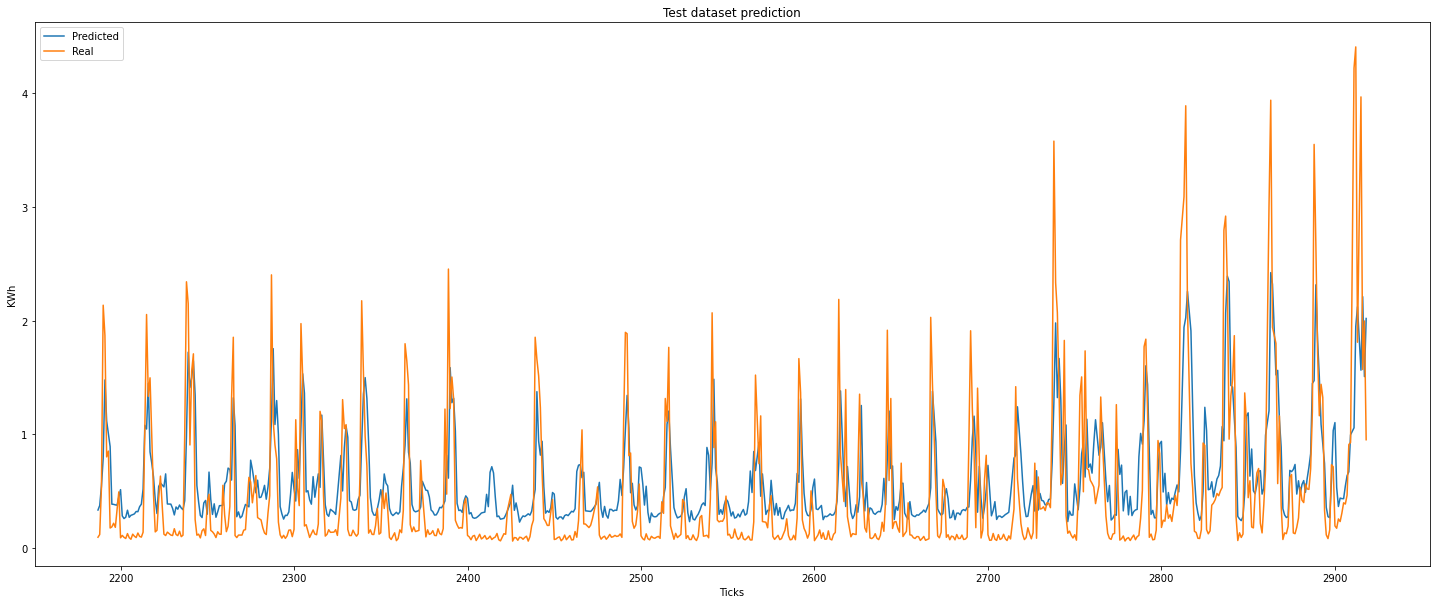

In [483]:
#plotting output
plt.rcParams["figure.figsize"] = (25,10)
plt.plot(weather_energy.index[2082:2784], data_predict, label = 'Predicted')
plt.plot(weather_energy.index[2082:2784],y_test[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()

In [484]:
test_score = mean_squared_error(y_test[1], data_predict)
print('Test MSE: %.3f' % test_score)

Test MSE: 0.228


In [485]:
r2_score(y_test[1], data_predict)

0.4713947250622633

# LSTM Meta Learner

In [1058]:
# utilities functions
def save_ckpt(episode, metalearner, optim, save):
    if not os.path.exists(os.path.join(save, 'ckpts')):
        os.mkdir(os.path.join(save, 'ckpts'))

    torch.save({
        'episode': episode,
        'metalearner': metalearner.state_dict(),
        'optim': optim.state_dict()
    }, os.path.join(save, 'ckpts', 'meta-learner-{}.pth.tar'.format(episode)))


def resume_ckpt(metalearner, optim, resume, device):
    ckpt = torch.load(resume, map_location=device)
    last_episode = ckpt['episode']
    metalearner.load_state_dict(ckpt['metalearner'])
    optim.load_state_dict(ckpt['optim'])
    return last_episode, metalearner, optim


def preprocess_grad_loss(x):
    p = 10
    indicator = (x.abs() >= np.exp(-p)).to(torch.float32)

    # preproc1
    x_proc1 = indicator * torch.log(x.abs() + 1e-8) / p + (1 - indicator) * -1
    # preproc2
    x_proc2 = indicator * torch.sign(x) + (1 - indicator) * np.exp(p) * x
    return torch.stack((x_proc1, x_proc2), 1)

In [1059]:
# Meta Learner module definition
class MetaLSTMCell(nn.Module):
    """C_t = f_t * C_{t-1} + i_t * \tilde{C_t}"""
    def __init__(self, input_size, hidden_size, n_learner_params):
        super(MetaLSTMCell, self).__init__()
        """Args:
            input_size (int): cell input size, default = 20
            hidden_size (int): should be 1
            n_learner_params (int): number of learner's parameters
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.n_learner_params = n_learner_params
        self.WF = nn.Parameter(torch.Tensor(input_size + 2, hidden_size))
        self.WI = nn.Parameter(torch.Tensor(input_size + 2, hidden_size))
        self.cI = nn.Parameter(torch.Tensor(n_learner_params, 1))
        self.bI = nn.Parameter(torch.Tensor(1, hidden_size))
        self.bF = nn.Parameter(torch.Tensor(1, hidden_size))

        self.reset_parameters()

    def reset_parameters(self):
        for weight in self.parameters():
            nn.init.uniform_(weight, -0.01, 0.01)

        # want initial forget value to be high and input value to be low so that 
        #  model starts with gradient descent
        nn.init.uniform_(self.bF, 4, 6)
        nn.init.uniform_(self.bI, -5, -4)

    def init_cI(self, flat_params):
        self.cI.data.copy_(flat_params.unsqueeze(1))

    def forward(self, inputs, hx=None):
        """Args:
            inputs = [x_all, grad]:
                x_all (torch.Tensor of size [n_learner_params, input_size]): outputs from previous LSTM
                grad (torch.Tensor of size [n_learner_params]): gradients from learner
            hx = [f_prev, i_prev, c_prev]:
                f (torch.Tensor of size [n_learner_params, 1]): forget gate
                i (torch.Tensor of size [n_learner_params, 1]): input gate
                c (torch.Tensor of size [n_learner_params, 1]): flattened learner parameters
        """
        x_all, grad = inputs
        batch, _ = x_all.size()

        if hx is None:
            f_prev = torch.zeros((batch, self.hidden_size)).to(self.WF.device)
            i_prev = torch.zeros((batch, self.hidden_size)).to(self.WI.device)
            c_prev = self.cI
            hx = [f_prev, i_prev, c_prev]

        f_prev, i_prev, c_prev = hx
        
        # f_t = sigmoid(W_f * [grad_t, loss_t, theta_{t-1}, f_{t-1}] + b_f)
        f_next = torch.mm(torch.cat((x_all, c_prev, f_prev), 1), self.WF) + self.bF.expand_as(f_prev)
        # i_t = sigmoid(W_i * [grad_t, loss_t, theta_{t-1}, i_{t-1}] + b_i)
        i_next = torch.mm(torch.cat((x_all, c_prev, i_prev), 1), self.WI) + self.bI.expand_as(i_prev)
        # next cell/params
        c_next = torch.sigmoid(f_next).mul(c_prev) - torch.sigmoid(i_next).mul(grad)

        return c_next, [f_next, i_next, c_next]

    def extra_repr(self):
        s = '{input_size}, {hidden_size}, {n_learner_params}'
        return s.format(**self.__dict__)


class MetaLearner(nn.Module):

    def __init__(self, input_size, hidden_size, n_learner_params):
        super(MetaLearner, self).__init__()
        """Args:
            input_size (int): for the first LSTM layer, default = 4
            hidden_size (int): for the first LSTM layer, default = 20
            n_learner_params (int): number of learner's parameters
        """
        self.lstm = nn.LSTMCell(input_size=input_size, hidden_size=hidden_size)
        self.metalstm = MetaLSTMCell(input_size=hidden_size, hidden_size=1, n_learner_params=n_learner_params)

    def forward(self, inputs, hs=None):
        """Args:
            inputs = [loss, grad_prep, grad]
                loss (torch.Tensor of size [1, 2])
                grad_prep (torch.Tensor of size [n_learner_params, 2])
                grad (torch.Tensor of size [n_learner_params])
            hs = [(lstm_hn, lstm_cn), [metalstm_fn, metalstm_in, metalstm_cn]]
        """
        loss, grad_prep, grad = inputs
        loss = loss.expand_as(grad_prep)
        inputs = torch.cat((loss, grad_prep), 1)   # [n_learner_params, 4]

        if hs is None:
            hs = [None, None]

        lstmhx, lstmcx = self.lstm(inputs, hs[0])
        flat_learner_unsqzd, metalstm_hs = self.metalstm([lstmhx, grad], hs[1])

        return flat_learner_unsqzd.squeeze(), [(lstmhx, lstmcx), metalstm_hs]

In [1060]:
# Learner module definition
class Learner(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob):
        super(Learner, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.model = nn.ModuleDict({'features': nn.Sequential(OrderedDict([
            ('lstm', nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bidirectional = True))]))})
        self.model.update({'linear': nn.Linear(hidden_dim*2, output_dim)})
        self.criterion = nn.MSELoss()

    def forward(self, x):
        # Initializing hidden state for first input with zeros
        h0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_()

        # Initializing cell state for first input with zeros
        c0 = torch.zeros(self.layer_dim*2, x.size(0), self.hidden_dim).requires_grad_()

        # We need to detach as we are doing truncated backpropagation through time (BPTT)
        # If we don't, we'll backprop all the way to the start even after going through another batch
        # Forward propagation by passing in the input, hidden state, and cell state into the model
        out = self.model.features(x)

        # Reshaping the outputs in the shape of (batch_size, seq_length, hidden_size)
        # so that it can fit into the fully connected layer
        #out = out[:, -1, :]
        out = out[0].squeeze(2)
        # Convert the final state to our desired output shape (batch_size, output_dim)
        out = self.model.linear(out)

        return out
    def get_flat_params(self):
        return torch.cat([p.view(-1) for p in self.model.parameters()], 0)

    def copy_flat_params(self, cI):
        idx = 0
        for p in self.model.parameters():
            plen = p.view(-1).size(0)
            p.data.copy_(cI[idx: idx+plen].view_as(p))
            idx += plen

    def transfer_params(self, learner_w_grad, cI):
        # Use load_state_dict only to copy the running mean/var in batchnorm, the values of the parameters
        #  are going to be replaced by cI
        self.load_state_dict(learner_w_grad.state_dict())
        #  replace nn.Parameters with tensors from cI (NOT nn.Parameters anymore).
        idx = 0
        for m in self.model.modules():            
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.Linear):
                wlen = m._parameters['weight'].view(-1).size(0)
                m._parameters['weight'] = cI[idx: idx+wlen].view_as(m._parameters['weight']).clone()
                idx += wlen
                if m._parameters['bias'] is not None:
                    blen = m._parameters['bias'].view(-1).size(0)
                    m._parameters['bias'] = cI[idx: idx+blen].view_as(m._parameters['bias']).clone()
                    idx += blen
            if isinstance(m, nn.LSTM):
                wlen = m._parameters['weight_ih_l0'].view(-1).size(0)
                m._parameters['weight_ih_l0'] = cI[idx: idx+wlen].view_as(m._parameters['weight_ih_l0']).clone()
                idx += wlen
                if m._parameters['weight_hh_l0'] is not None:
                    blen = m._parameters['weight_hh_l0'].view(-1).size(0)
                    m._parameters['weight_hh_l0'] = cI[idx: idx+blen].view_as(m._parameters['weight_hh_l0']).clone()
                    idx += blen
                if m._parameters['bias_ih_l0'] is not None:
                    blen = m._parameters['bias_ih_l0'].view(-1).size(0)
                    m._parameters['bias_ih_l0'] = cI[idx: idx+blen].view_as(m._parameters['bias_ih_l0']).clone()
                    idx += blen
                if m._parameters['bias_hh_l0'] is not None:
                    blen = m._parameters['bias_hh_l0'].view(-1).size(0)
                    m._parameters['bias_hh_l0'] = cI[idx: idx+blen].view_as(m._parameters['bias_hh_l0']).clone()
                    idx += blen

    def reset_batch_stats(self):
        for m in self.modules():
            if isinstance(m, nn.BatchNorm2d):
                m.reset_running_stats()

In [ ]:
#parameters
input_size = 23
hidden_layers = 50
meta_hidden_layers = 20
meta_input_layers = 4
lstm_layers = 3
num_classes = 1
dropout_proba = 0.2
epochs = 500
batch_size = 100

In [1068]:
# Train learner 
def train_learner(learner_w_grad, metalearner, train_input, train_target, epoch, batch_size):
    cI = metalearner.metalstm.cI.data
    hs = [None]
    for _ in range(epoch):
        for i in range(0, len(train_input), batch_size):
            x = train_input[i:i+batch_size]
            y = train_target[i:i+batch_size]
            # get the loss/grad
            learner_w_grad.copy_flat_params(cI)
            output = learner_w_grad(x)
            loss = learner_w_grad.criterion(output.squeeze(2), y)
            learner_w_grad.zero_grad()
            loss.backward()
            grad = torch.cat([p.grad.data.view(-1) / batch_size for p in learner_w_grad.parameters()], 0)

            # preprocess grad & loss and metalearner forward
            grad_prep = preprocess_grad_loss(grad)  # [n_learner_params, 2]
            loss_prep = preprocess_grad_loss(loss.data.unsqueeze(0)) # [1, 2]
            metalearner_input = [loss_prep, grad_prep, grad.unsqueeze(1)]
            cI, h = metalearner(metalearner_input, hs[-1])
            hs.append(h)


    return cI


seed = random.randint(0, 1e3)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

#torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
device = torch.device('cpu')

# Set up learner, meta-learner
learner_w_grad = Learner(input_size, hidden_layers, lstm_layers, num_classes, dropout_proba).to(device)
learner_wo_grad = copy.deepcopy(learner_w_grad)
metalearner = MetaLearner(meta_input_layers, meta_hidden_layers, learner_w_grad.get_flat_params().size(0)).to(device)
metalearner.metalstm.init_cI(learner_w_grad.get_flat_params())

# Set up loss, optimizer, learning rate scheduler
optim = torch.optim.Adam(metalearner.parameters(), lr = 0.1)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=100, gamma=0.9)
# Meta-training
for task in range(len(X_train)):
    train_input =  Variable(torch.tensor(X_train_meta[task].values, dtype=torch.float32, device = device))
    train_input =  torch.reshape(train_input, (train_input.shape[0], 1, train_input.shape[1]))

    train_target = Variable(torch.tensor((y_train_meta[task].values), dtype=torch.float32, device = device))
    test_input = Variable(torch.tensor(X_val_meta_dl[task].values, dtype=torch.float32, device = device))
    test_input = torch.reshape(test_input,   (test_input.shape[0], 1, test_input.shape[1]))

    test_target = Variable(torch.tensor((y_val_meta_dl[task].values), dtype=torch.float32, device = device))

    # Train learner with metalearner
    learner_w_grad.reset_batch_stats()
    learner_wo_grad.reset_batch_stats()
    learner_w_grad.train()
    learner_wo_grad.train()
    cI = train_learner(learner_w_grad, metalearner, train_input, train_target, epochs, batch_size)

    # Train meta-learner with validation loss
    learner_wo_grad.transfer_params(learner_w_grad, cI)
    output = learner_wo_grad(test_input)
    loss = learner_wo_grad.criterion(output.squeeze(2), test_target)
    print('validation loss', loss)

    optim.zero_grad()
    loss.backward()
    optim.step()



validation loss tensor(0.5915, grad_fn=<MseLossBackward0>)
validation loss tensor(0.7996, grad_fn=<MseLossBackward0>)
validation loss tensor(14.2352, grad_fn=<MseLossBackward0>)
validation loss tensor(0.6020, grad_fn=<MseLossBackward0>)
validation loss tensor(0.4330, grad_fn=<MseLossBackward0>)
validation loss tensor(0.4134, grad_fn=<MseLossBackward0>)
validation loss tensor(0.7401, grad_fn=<MseLossBackward0>)
validation loss tensor(0.2061, grad_fn=<MseLossBackward0>)
validation loss tensor(0.6284, grad_fn=<MseLossBackward0>)
validation loss tensor(0.5960, grad_fn=<MseLossBackward0>)
validation loss tensor(0.1321, grad_fn=<MseLossBackward0>)
validation loss tensor(0.9698, grad_fn=<MseLossBackward0>)
validation loss tensor(0.6162, grad_fn=<MseLossBackward0>)
validation loss tensor(0.7166, grad_fn=<MseLossBackward0>)
validation loss tensor(4.7635, grad_fn=<MseLossBackward0>)
validation loss tensor(0.2892, grad_fn=<MseLossBackward0>)
validation loss tensor(0.4086, grad_fn=<MseLossBackward

In [1077]:
#adjusting for needed task
train_input =  Variable(torch.tensor(X_train_meta[1].values, dtype=torch.float32, device = device))
train_input =  torch.reshape(train_input, (train_input.shape[0], 1, train_input.shape[1]))
train_target = Variable(torch.tensor((y_train_meta[1].values), dtype=torch.float32, device = device))

learner_w_grad.reset_batch_stats()
learner_wo_grad.reset_batch_stats()
learner_w_grad.train()
learner_wo_grad.eval()

cI = train_learner(learner_w_grad, metalearner, train_input, train_target, 500, 50)
learner_wo_grad.transfer_params(learner_w_grad, cI)

In [1078]:
# test set
test_input = torch.tensor(X_test[1].values, dtype=torch.float32, device = device)
test_input = torch.reshape(test_input,   (test_input.shape[0], 1, test_input.shape[1]))

output = learner_wo_grad(test_input)
data_predict = output.cpu().data.numpy() #numpy conversion
data_predict = data_predict.squeeze(2)

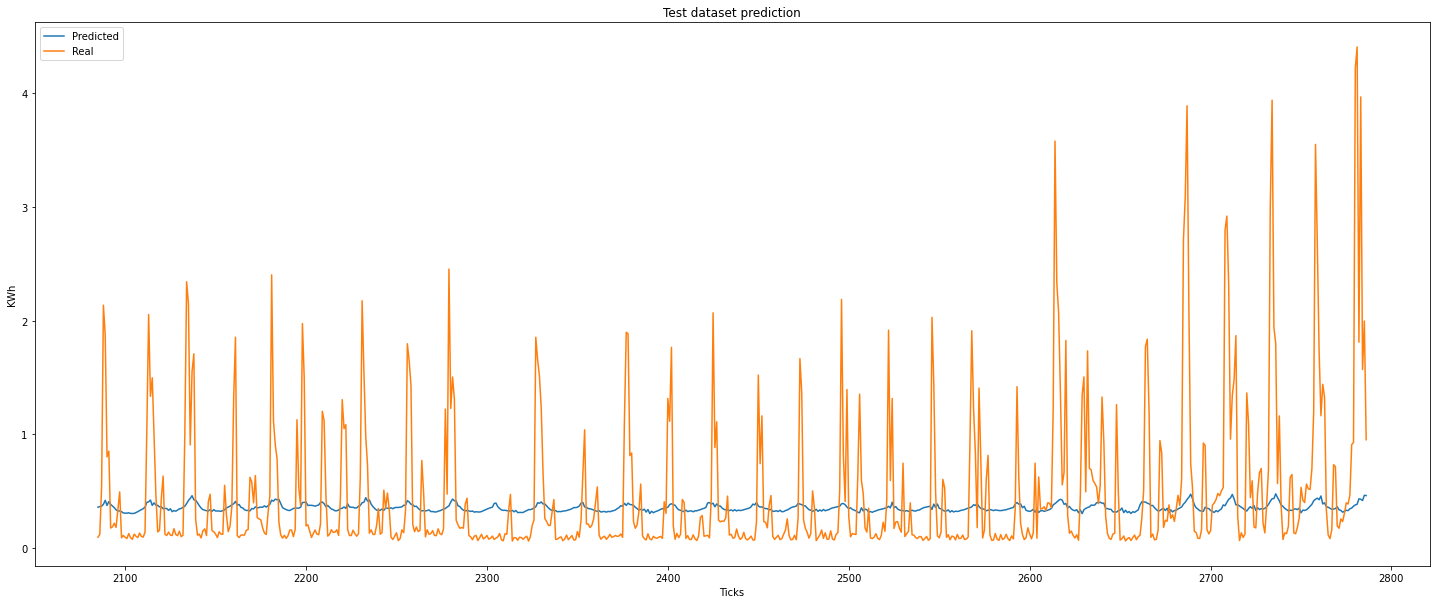

In [1079]:
# plot the outcome
plt.figure(figsize = (25,10))
plt.plot(weather_energy.index[:len(data_predict)], data_predict, label = 'Predicted')
plt.plot(weather_energy.index[:len(data_predict)],y_test[1], label = 'Real')
plt.title('Test dataset prediction')
plt.xlabel('Ticks')
plt.ylabel('KWh')
plt.legend()